# DSC-75 Daily Type

Author: Dan E

Date: 2023-07-07

Description: This will investigate the role the feature "daily" plays in the model. It will also investigate the "DailyType" feature. This is the categorical version of this feature, it is not versioned but it is assumed to not be an important role. This can be investigated in how often this changes but will not be considered here.

The notebook will consist of the following analysis:

* Impact of "daily" on model accuracy.
* Impact of "daily" on model predictions.
* Impact of "DailyType" on model accuracy.
* Impact of "DailyType" on model predictions.

The notebook will be split into the following sections:

* Imports
* Import Model Data
* Create Baseline Model (without daily)
* Create "daily" Model
* Create "DailyType" Model
* "daily" predictions Analysis
* "DailyType" predictions Analysis
* Summary

Remark: The feature is not "daily pricing", this needs further investigation.

Reamrk: The impact of the feature will change the impact of other features. That will be ignored in this notebook.

In [1]:
import os
from IPython.display import Image

def confluence_plot(figure):
    fig = figure
    fig.write_image("temp_confluence_image.png", engine='orca', scale=4)
    im = Image("temp_confluence_image.png")
    os.remove("temp_confluence_image.png")
    return im

## Imports

In [2]:
import platform
import pyodbc
import pandas as pd
import json
import numpy as np
from datetime import datetime as dt, date as checkdate, timedelta
import plotly.express as px
from sqlalchemy.engine import URL
from sqlalchemy import create_engine, text
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import joblib
import plotly.express as px

import platform
import pyodbc
import pandas as pd
import json
import numpy as np
from datetime import datetime as dt, date as checkdate, timedelta
import plotly.express as px

from ModelBuildTemplateOutliers import ModelBuild as MBD2

model_params = {'iterations':400}

In [3]:
def wape(actual,pred):
    wape = 100*np.abs(actual - pred).sum() / actual.sum()
    return wape

def smape(actual, pred):
    val = 100/len(actual) * np.sum(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred)))
    return val

from sklearn.metrics import r2_score,mean_squared_error

In [4]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

In [5]:
def fetch_SQLserver_data(sql_code,conn_string):
    """
    Uses pyodbc.connect and pandas.read_sql to return query results as dataframe.
    :param sql_code: string, query to be submitted
    :param conn_string: string, full connection details as string
    """
    connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_string})
    engine = create_engine(connection_url)
    with engine.connect() as conn:
        df = pd.read_sql(sql=text(sql_code), con=conn)
        conn.commit()
    print('Data Imported')
    return df

In [6]:
if platform.system() == 'Windows':
	conn_CDM = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=CDM;trusted_connection=Yes'
	conn_l0 = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=Sykes_DW_Level0_Staging;trusted_connection=Yes'
	conn_l2 = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=Sykes_DW_Level2_ADM;trusted_connection=Yes'
	conn_BOX = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=BI-DATA-PROD-02;DATABASE=Box;trusted_connection=Yes'

## Import Model Data

In [7]:
mb = MBD2(1)

In [8]:
datasets = mb.build_data_sets()

Data Imported
Data Imported
Data Imported
Data Imported
Data Imported
Data Imported
Data Imported


In [9]:
train_data, test_data = datasets

## Create Baseline Model (without daily)

In [10]:
initial_train_features = [
    'AllowsPets',
    'Bathrooms',
    'Bedrooms',
    'ChangeOverDay',
    'PropertyType',
    'Rating',
    'Sleeps',
    'isHoneyPot',
    'LocationType',
    'WorkingRegion',
    'CommissionRate',
    'RevenueManagementOption',
    'hasBroadband',
    'hasDishwasher',
    'hasEnclosedGarden',
    'hasGames', 
    'hasGarden',
    'hasHotTub',
    'hasOffRoadParking',
    'hasOpenFire',
    'OwnerBookingTier',
    'BasePriceSterling',
    'hasShortBreaksAllowed',
    'hasLastMinuteBreakAllowed',
    'owner_led_pricing'
]

initial_cat_features = [
    'AllowsPets',
    'ChangeOverDay',
    'PropertyType',
    'Rating',
    'isHoneyPot',
    'LocationType', 
    'WorkingRegion',
    'RevenueManagementOption',
    'hasBroadband',
    'hasDishwasher',
    'hasEnclosedGarden',
    'hasGames',
    'hasGarden',
    'hasHotTub',
    'hasOffRoadParking',
    'hasOpenFire',
    'OwnerBookingTier',
    'hasShortBreaksAllowed',
    'hasLastMinuteBreakAllowed',
    'owner_led_pricing'
]

In [11]:
train_data_1 = train_data.copy()
test_data_1 = test_data.copy()

In [12]:
train_data_1 = train_data_1[initial_train_features + ['PropertyReference', 'TrainLabel']]
test_data_1 = test_data_1[initial_train_features + ['PropertyReference', 'TestLabel']]

In [13]:
X_train = train_data_1[initial_train_features].copy()
y_train = train_data_1['TrainLabel'].values

In [14]:
model_1 = CatBoostRegressor(**model_params)

model_1.fit(
    X=X_train,
    y=y_train,
    cat_features=initial_cat_features,
    plot=False,
    verbose = 0
         )

In [15]:
preds_train_1 = model_1.predict(train_data_1)
preds_test_1 = model_1.predict(test_data_1)

In [16]:
smape(train_data_1['TrainLabel'], preds_train_1)

19.926666545909466

In [17]:
wape(train_data_1['TrainLabel'], preds_train_1)

16.657460626055904

In [18]:
r2_score(train_data_1['TrainLabel'], preds_train_1)

0.8304801362382362

In [19]:
mean_squared_error(train_data_1['TrainLabel'], preds_train_1, squared=False)

1438.905135321375

In [20]:
smape(test_data_1['TestLabel'], preds_test_1)

28.598247387963628

In [21]:
wape(test_data_1['TestLabel'], preds_test_1)

25.92531426990651

In [22]:
mean_squared_error(test_data_1['TestLabel'], preds_test_1, squared=False)

2043.11677988361

## Create "daily" Model

In [23]:
initial_train_features = initial_train_features + ['daily']

initial_cat_features = initial_cat_features + ['daily']

In [24]:
train_data_2 = train_data.copy()
test_data_2 = test_data.copy()

In [25]:
train_data_2 = train_data_2[initial_train_features + ['PropertyReference', 'TrainLabel']]
test_data_2 = test_data_2[initial_train_features + ['PropertyReference', 'TestLabel']]

In [26]:
X_train = train_data_2[initial_train_features].copy()
y_train = train_data_2['TrainLabel'].values

In [27]:
model_2 = CatBoostRegressor(**model_params)

model_2.fit(
    X=X_train,
    y=y_train,
    cat_features=initial_cat_features,
    plot=False,
    verbose = 0
         )

In [28]:
preds_train_2 = model_2.predict(train_data_2)
preds_test_2 = model_2.predict(test_data_2)

In [29]:
smape(train_data_2['TrainLabel'], preds_train_2)

19.98858885681967

In [30]:
wape(train_data_2['TrainLabel'], preds_train_2)

16.666428824649962

In [31]:
r2_score(train_data_2['TrainLabel'], preds_train_2)

0.8300163559406493

In [32]:
mean_squared_error(train_data_2['TrainLabel'], preds_train_2, squared=False)

1440.8721025789962

In [33]:
smape(test_data_2['TestLabel'], preds_test_2)

28.627232488749158

In [34]:
wape(test_data_2['TestLabel'], preds_test_2)

25.94311985309166

In [35]:
r2_score(test_data_2['TestLabel'], preds_test_2)

0.6267500651863613

In [36]:
mean_squared_error(test_data_2['TestLabel'], preds_test_2, squared=False)

2044.5909174721082

## Create "DailyType" Model

In [37]:
SQL_DAILY = """
SELECT p.PropertyReference
,ISNULL(pl.DailyType, 'No') AS DailyType
FROM propertymanagement.PropertyLead pl
JOIN propertymanagement.Property p on pl.PropertyLeadID = p.PropertyLeadID
"""

In [38]:
daily_type = fetch_SQLserver_data(SQL_DAILY, conn_CDM)

Data Imported


In [39]:
train_data_3 = train_data.merge(daily_type, on='PropertyReference').copy()
test_data_3 = test_data.merge(daily_type, on='PropertyReference').copy()

In [40]:
initial_train_features = initial_train_features[:-1] + ['DailyType']

initial_cat_features = initial_cat_features[:-1] + ['DailyType']

In [41]:
train_data_3 = train_data_3[initial_train_features + ['PropertyReference', 'TrainLabel']]
test_data_3 = test_data_3[initial_train_features + ['PropertyReference', 'TestLabel']]

In [42]:
X_train = train_data_3[initial_train_features].copy()
y_train = train_data_3['TrainLabel'].values

In [43]:
model_3 = CatBoostRegressor(**model_params)

model_3.fit(
    X=X_train,
    y=y_train,
    cat_features=initial_cat_features,
    plot=False,
    verbose = 0
         )

In [44]:
preds_train_3 = model_3.predict(train_data_3)
preds_test_3 = model_3.predict(test_data_3)

In [45]:
smape(train_data_3['TrainLabel'], preds_train_3)

19.99622877727633

In [46]:
wape(train_data_3['TrainLabel'], preds_train_3)

16.74031758634266

In [47]:
r2_score(train_data_3['TrainLabel'], preds_train_3)

0.8265395636761185

In [48]:
mean_squared_error(train_data_3['TrainLabel'], preds_train_3, squared=False)

1455.5330878041584

In [49]:
smape(test_data_3['TestLabel'], preds_test_3)

28.6841988869387

In [50]:
wape(test_data_3['TestLabel'], preds_test_3)

25.955896435961996

In [51]:
r2_score(test_data_3['TestLabel'], preds_test_3)

0.6256120556264705

In [52]:
mean_squared_error(test_data_3['TestLabel'], preds_test_3, squared=False)

2047.705443372748

## "daily" Analysis

### Compare Predictions As Is

In [53]:
df_base = pd.DataFrame()
df_base['PropertyReference'] = test_data_1['PropertyReference']
df_base['BasePrediction'] = preds_test_1

df_daily = pd.DataFrame()
df_daily['PropertyReference'] = test_data_2['PropertyReference']
df_daily['daily'] = test_data_2.daily
df_daily['DailyPrediction'] = preds_test_2

df_comp = df_base.merge(df_daily, on='PropertyReference')
df_comp['PredictionDifference'] = df_comp['BasePrediction'] - df_comp['DailyPrediction']
df_comp['PercentageDifference'] = 100*df_comp['PredictionDifference']/df_comp['BasePrediction']

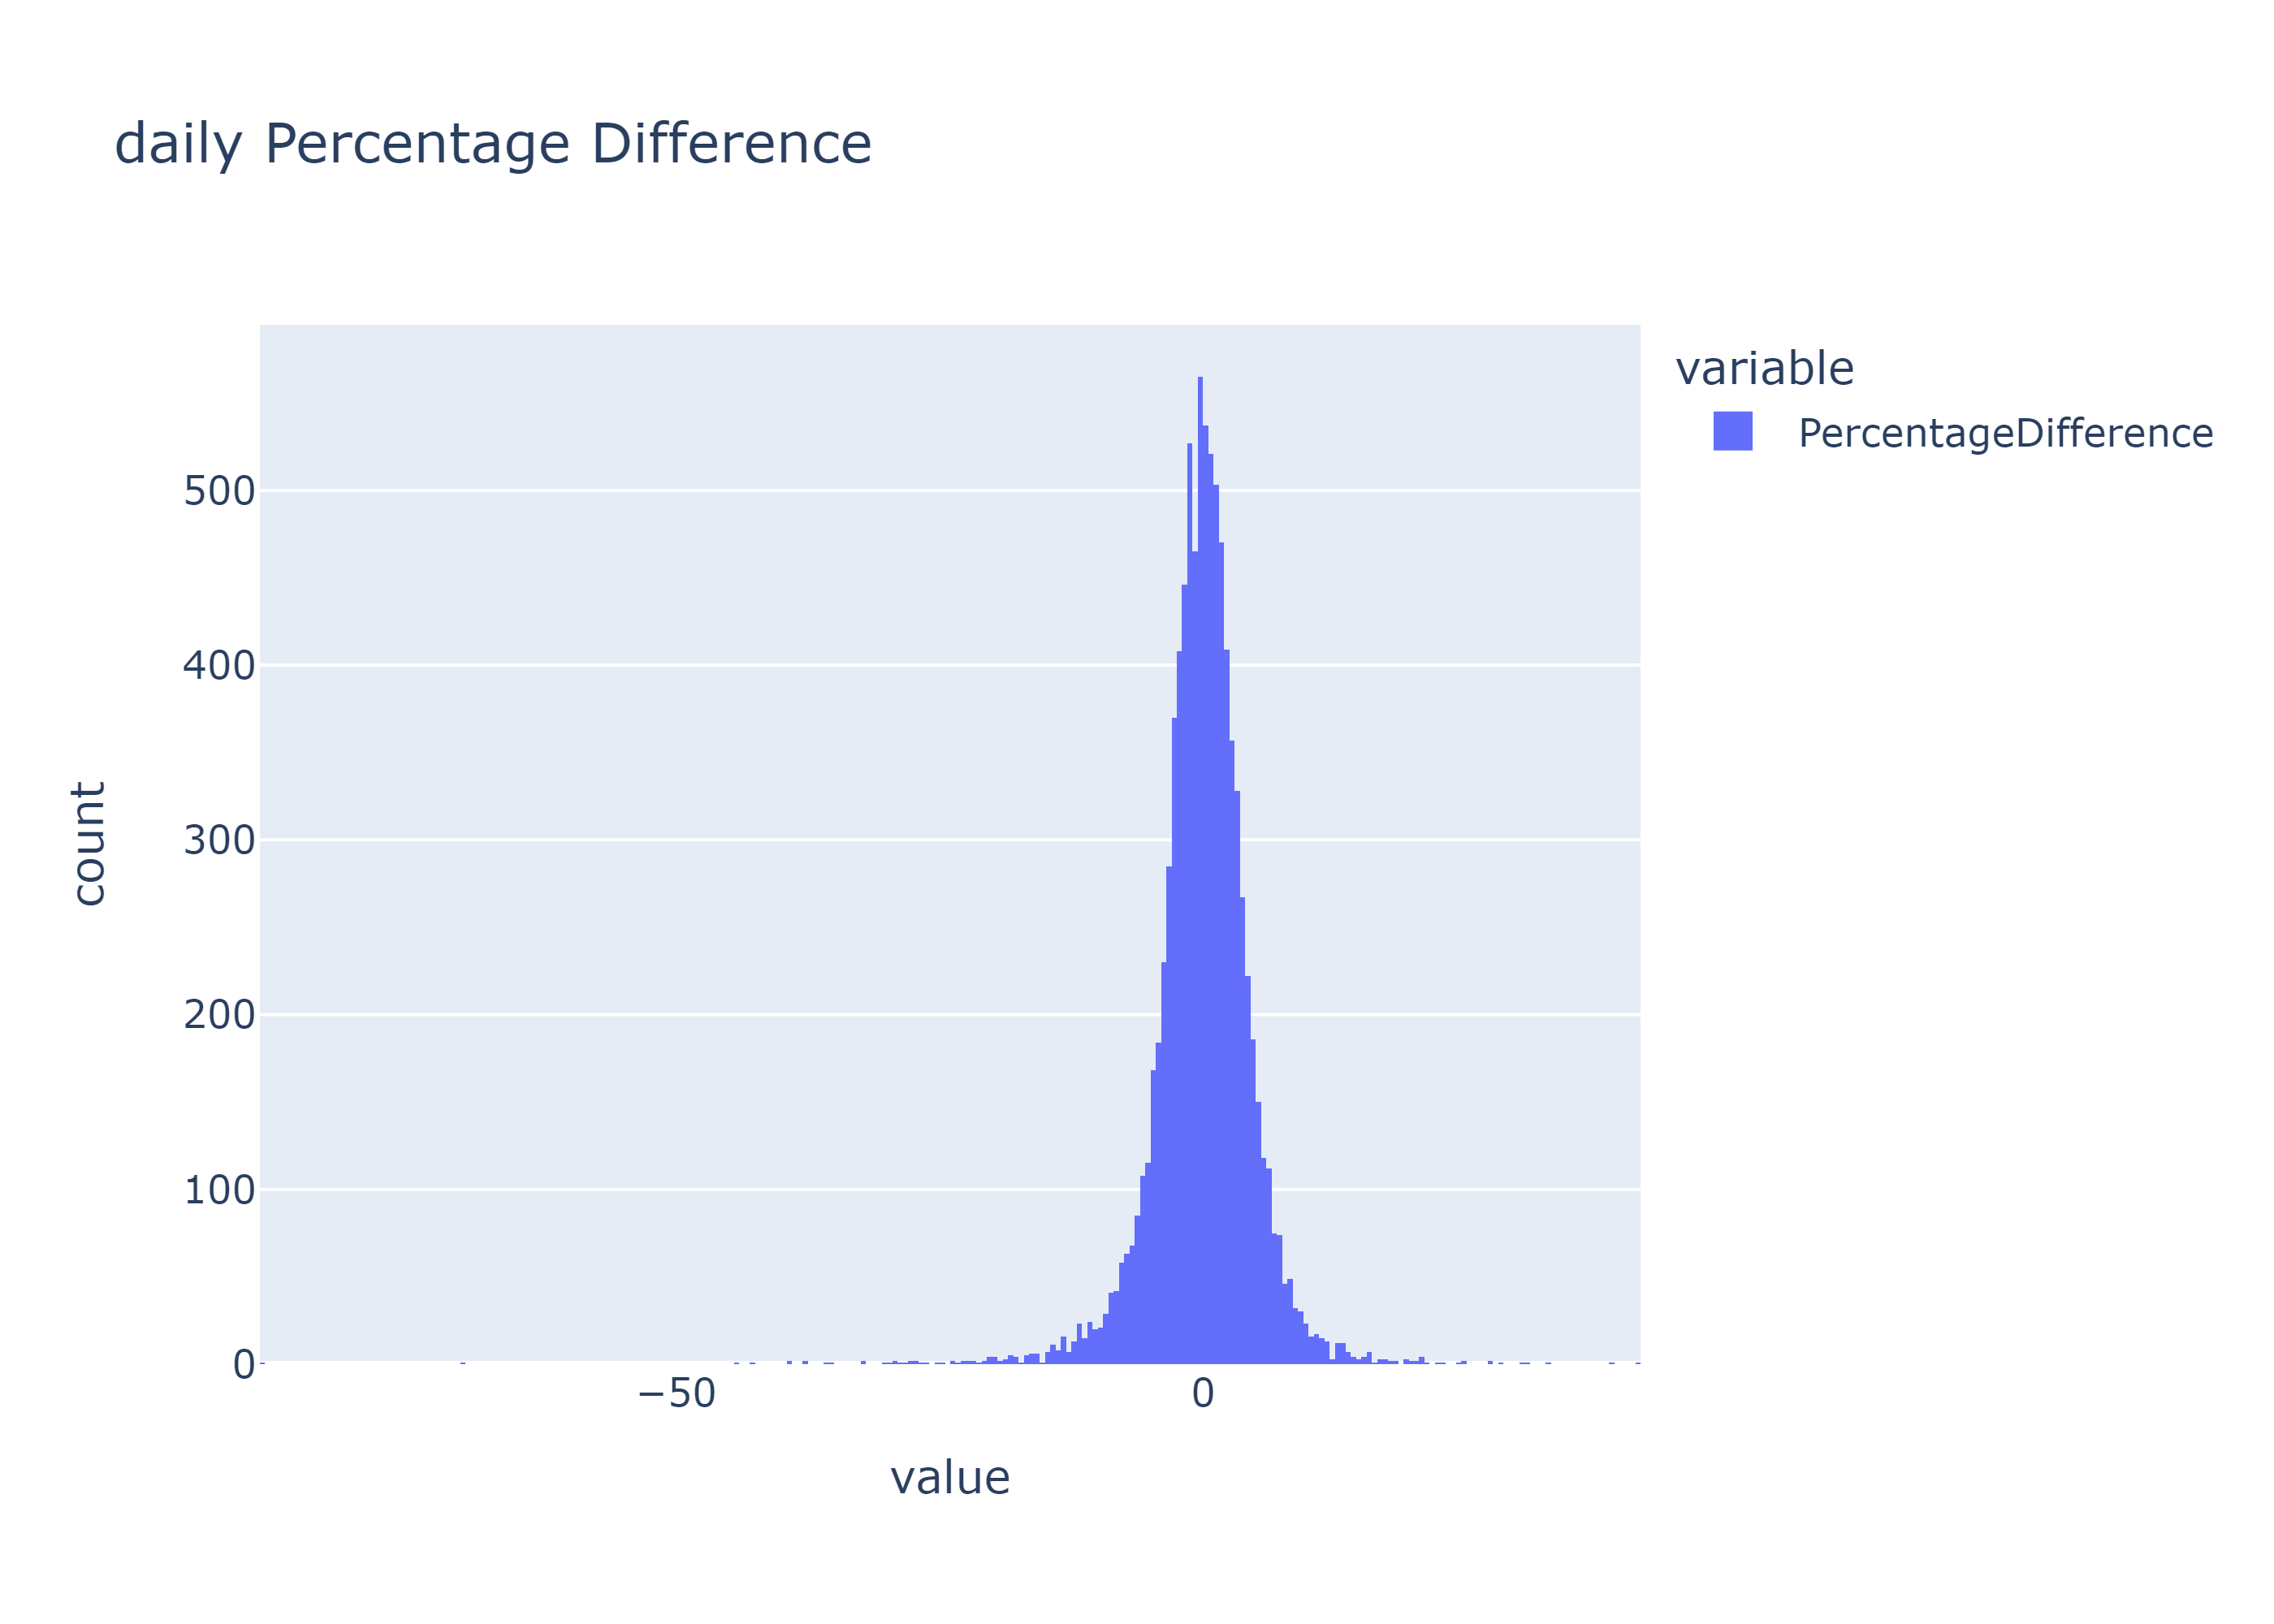

In [54]:
plot_data = df_comp.copy()
fig = px.histogram(plot_data['PercentageDifference'], title='daily Percentage Difference')
confluence_plot(fig)

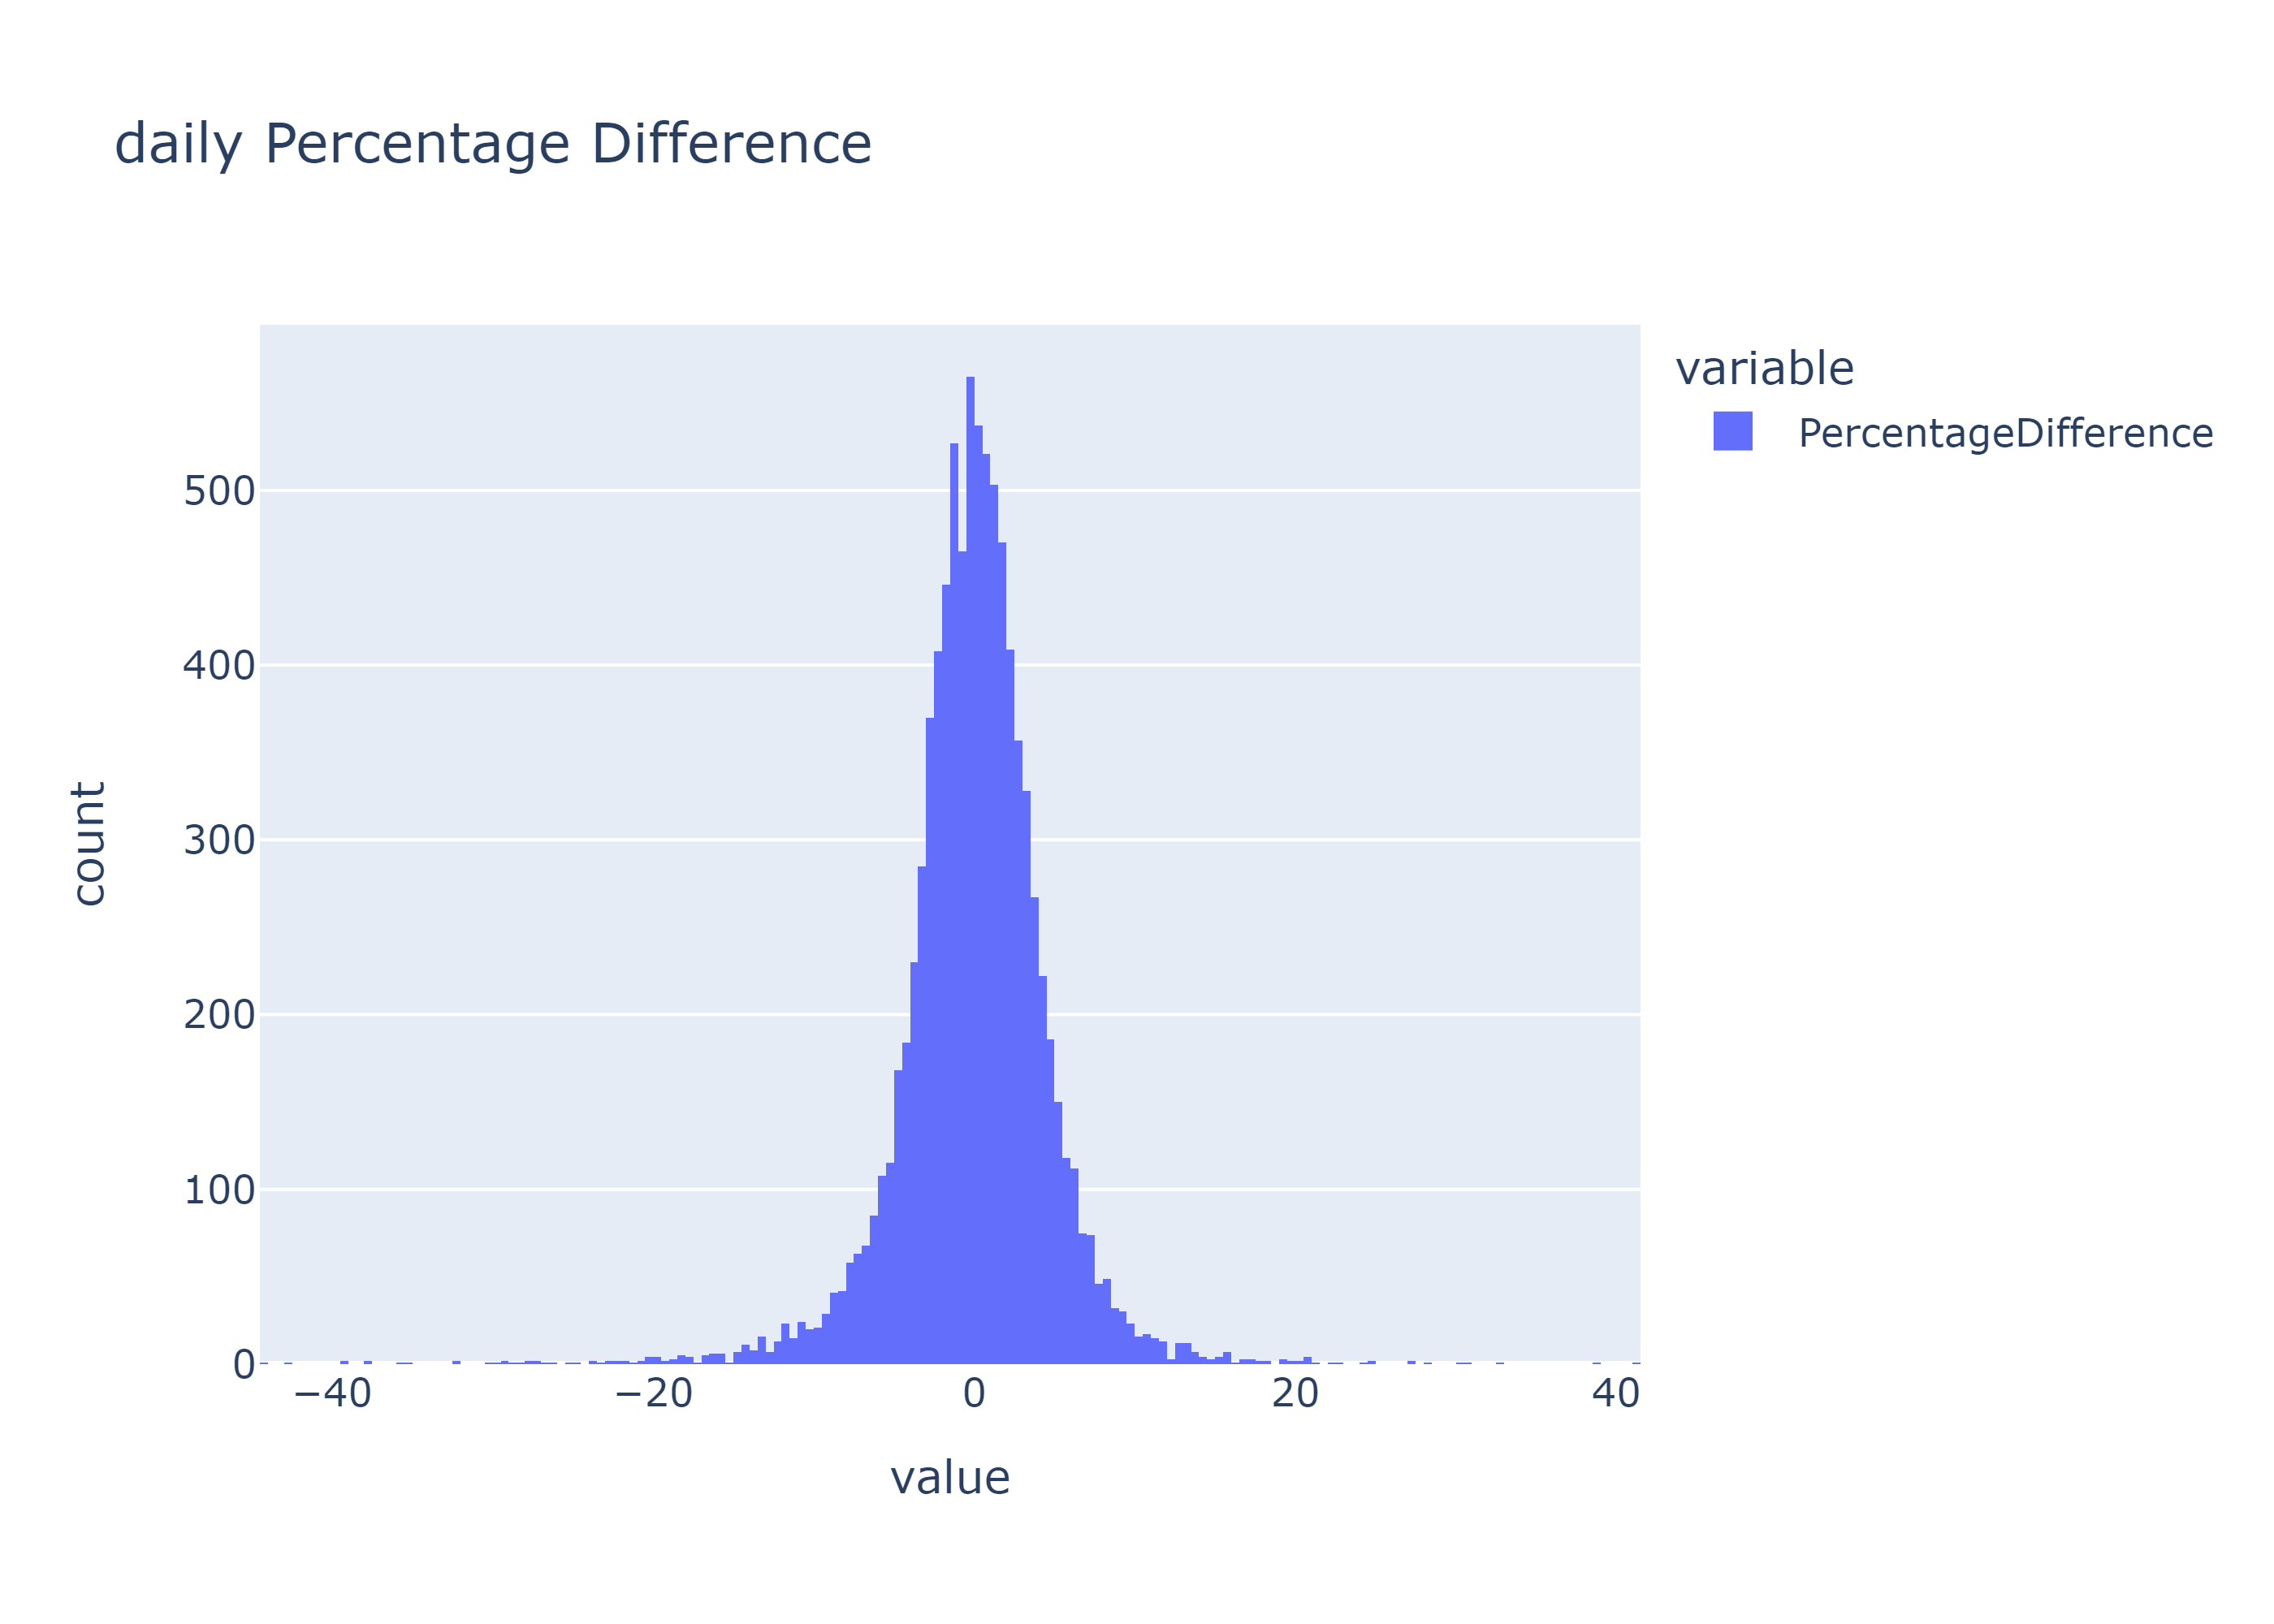

In [55]:
plot_data = df_comp.loc[df_comp['PercentageDifference'] > -50].copy()
fig = px.histogram(plot_data['PercentageDifference'], title='daily Percentage Difference')
confluence_plot(fig)

In [56]:
print(f"Mean Prediction difference: {df_comp['PredictionDifference'].mean():.2f}")
print(f"Mean Percentage difference: {df_comp['PercentageDifference'].mean():.2f}%")
print(f"Mean ABS Percentage difference: {abs(df_comp['PercentageDifference']).mean():.2f}%")

Mean Prediction difference: -3.05
Mean Percentage difference: -0.05%
Mean ABS Percentage difference: 3.26%


### Compare daily uplift

In [57]:
daily_0 = test_data_2.copy()
daily_0['daily'] = 0
daily_0_preds = model_2.predict(daily_0)

daily_1 = test_data_2.copy()
daily_1['daily'] = 1
daily_1_preds = model_2.predict(daily_1)

uplift = daily_1_preds - daily_0_preds
uplift_percentage = 100*uplift/daily_0_preds

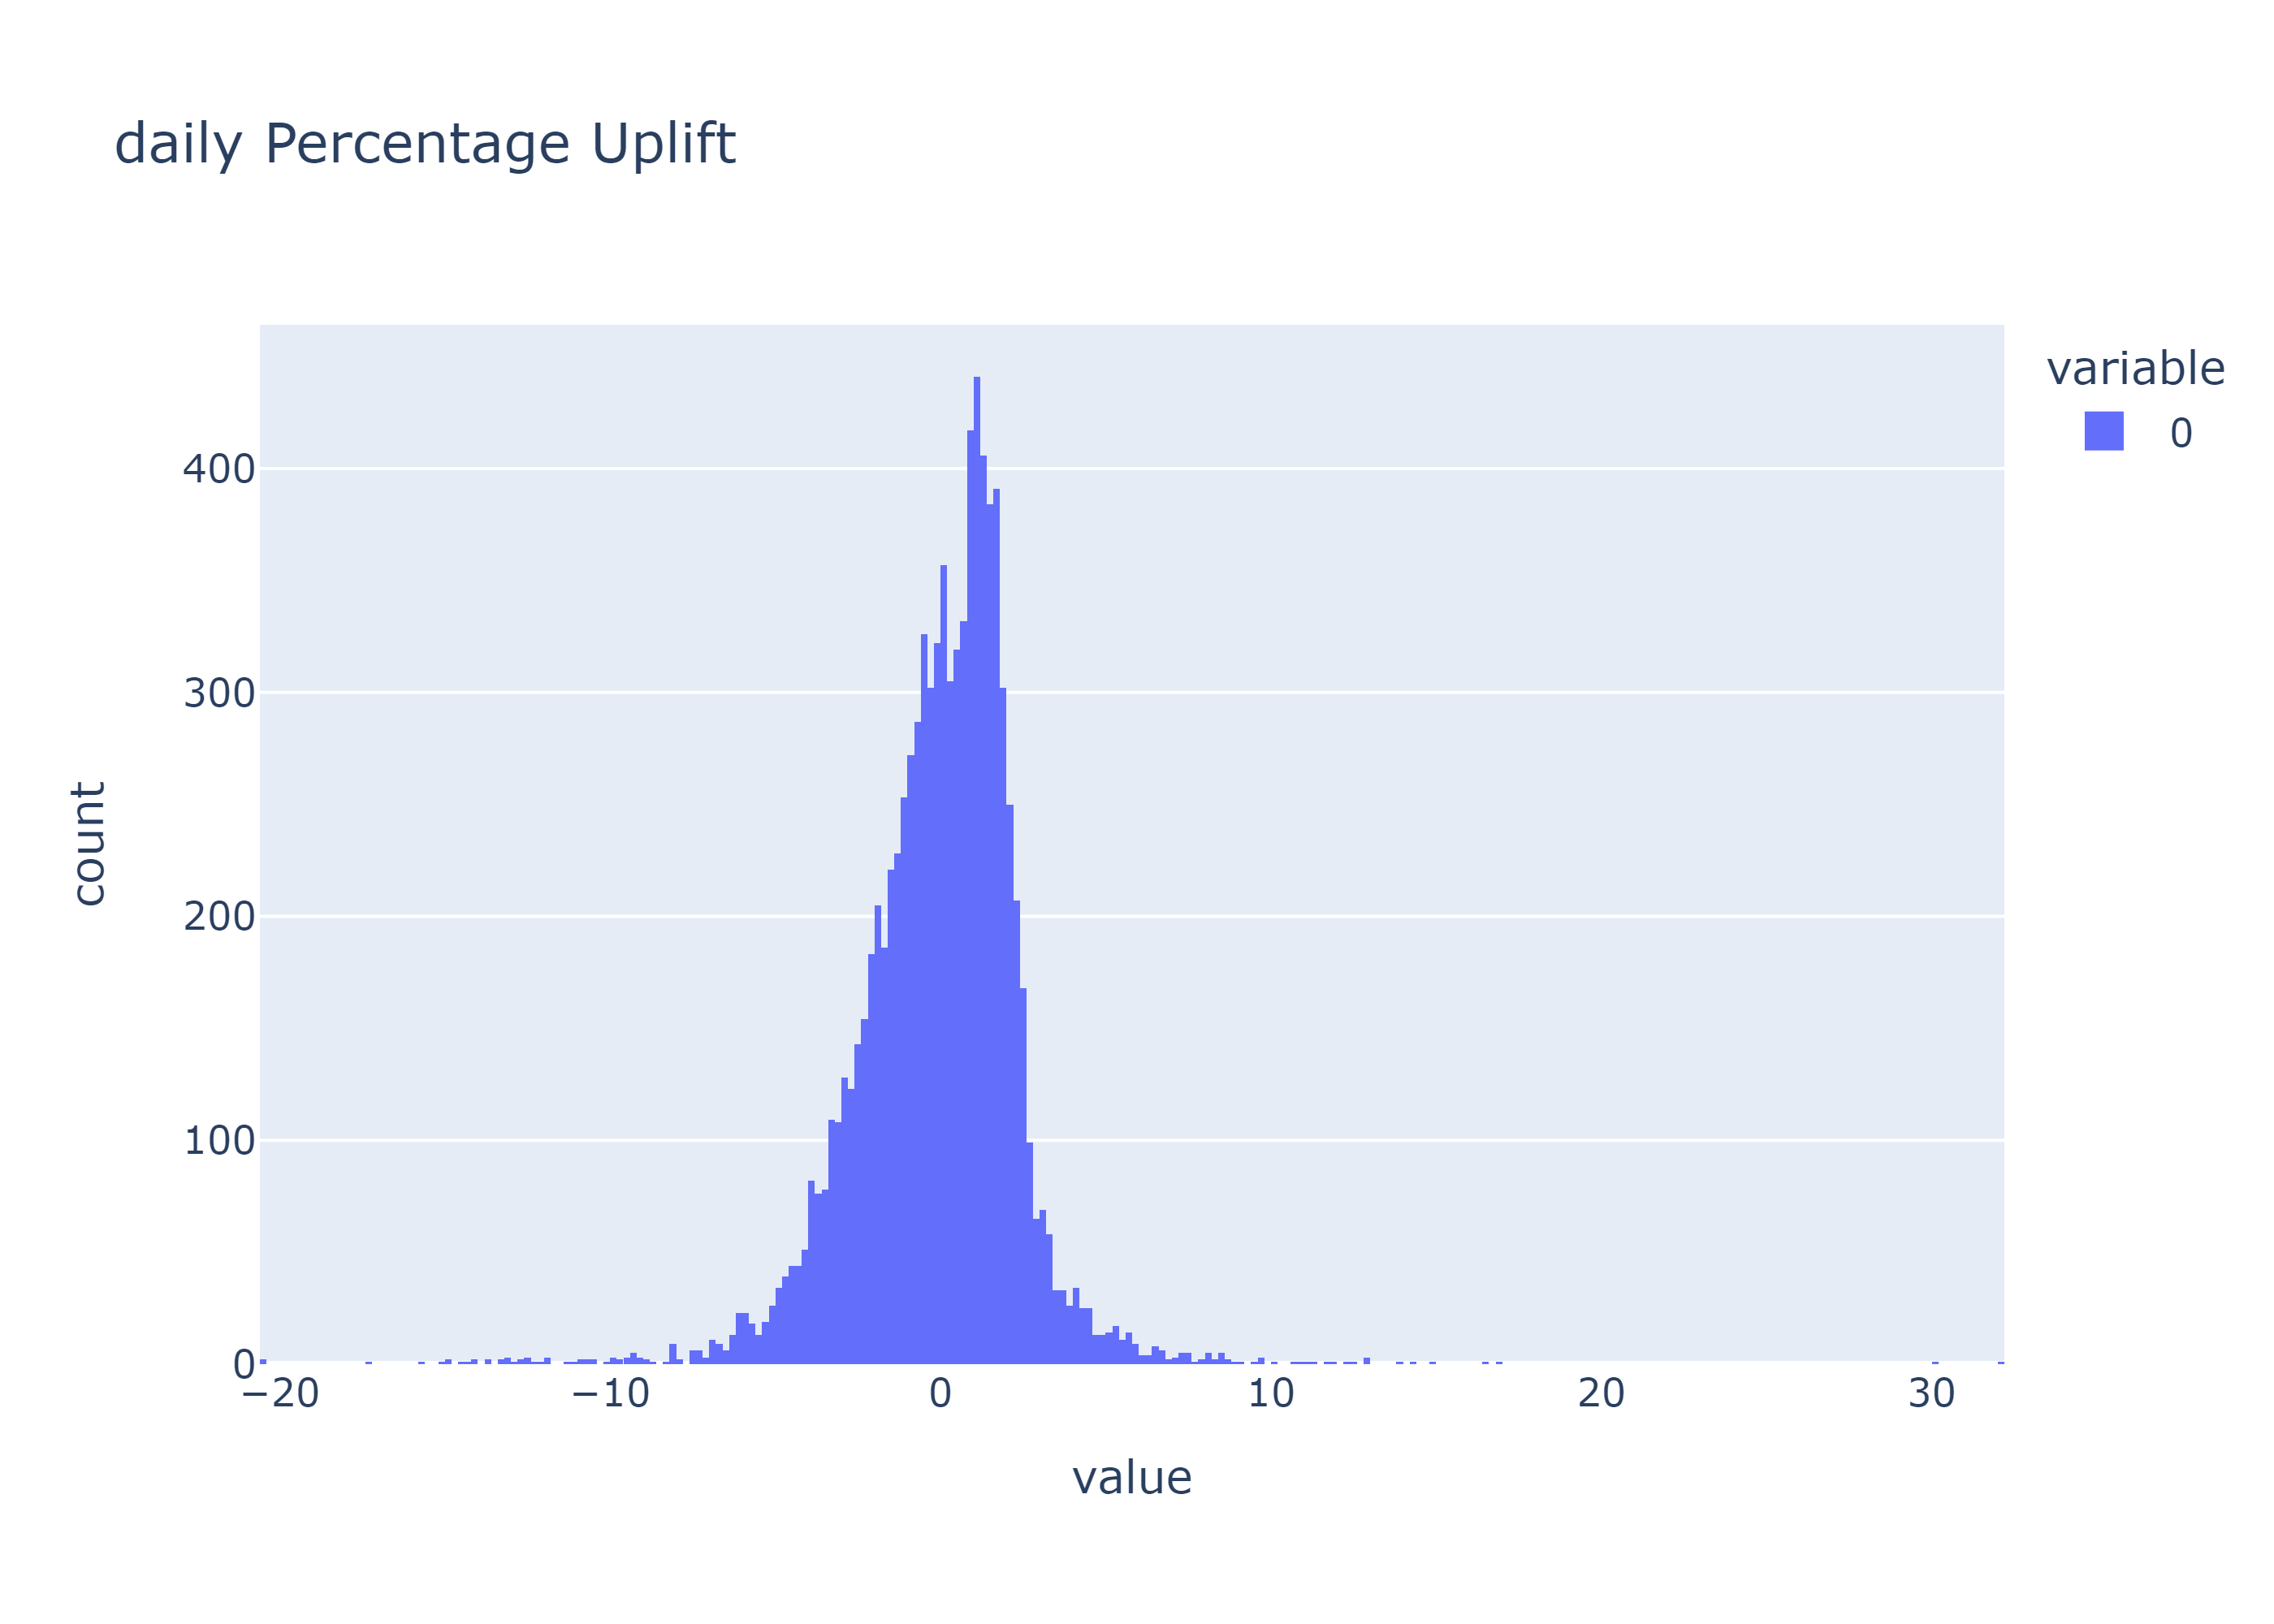

In [58]:
fig = px.histogram(uplift_percentage, title='daily Percentage Uplift')
confluence_plot(fig)

In [59]:
print(f"Mean Prediction Uplift: {uplift.mean():.2f}")
print(f"Mean Percentage Uplift: {uplift_percentage.mean():.2f}%")
print(f"Mean ABS Percentage Uplift: {abs(uplift_percentage).mean():.2f}%")

Mean Prediction Uplift: 14.90
Mean Percentage Uplift: -0.06%
Mean ABS Percentage Uplift: 1.79%


### ShortBreaks Impact

In [60]:
df_uplift = pd.DataFrame()
df_uplift['Uplift'] = uplift
df_uplift['PercentageUplift'] = uplift_percentage
df_uplift['hasShortBreaksAllowed'] = test_data_2['hasShortBreaksAllowed'].copy()
df_uplift['hasLastMinuteBreakAllowed'] = test_data_2['hasLastMinuteBreakAllowed'].copy()

In [61]:
df_uplift.groupby(['hasShortBreaksAllowed', 'hasLastMinuteBreakAllowed']).mean()

Uplift  PercentageUplift
hasShortBreaksAllowed hasLastMinuteBreakAllowed                             
False                 False                      14.849422         -0.062976
True                  False                      12.741238         -0.108823
                      True                       15.627267         -0.074730

## "DailyType" Analysis

In [62]:
df_daily_type = pd.DataFrame()
df_daily_type['PropertyReference'] = test_data_3['PropertyReference']
df_daily_type['DailyType'] = test_data_3.DailyType
df_daily_type['DailyPrediction'] = preds_test_3

df_comp = df_base.merge(df_daily_type, on='PropertyReference')
df_comp['PredictionDifference'] = df_comp['BasePrediction'] - df_comp['DailyPrediction']
df_comp['PercentageDifference'] = 100*df_comp['PredictionDifference']/df_comp['BasePrediction']

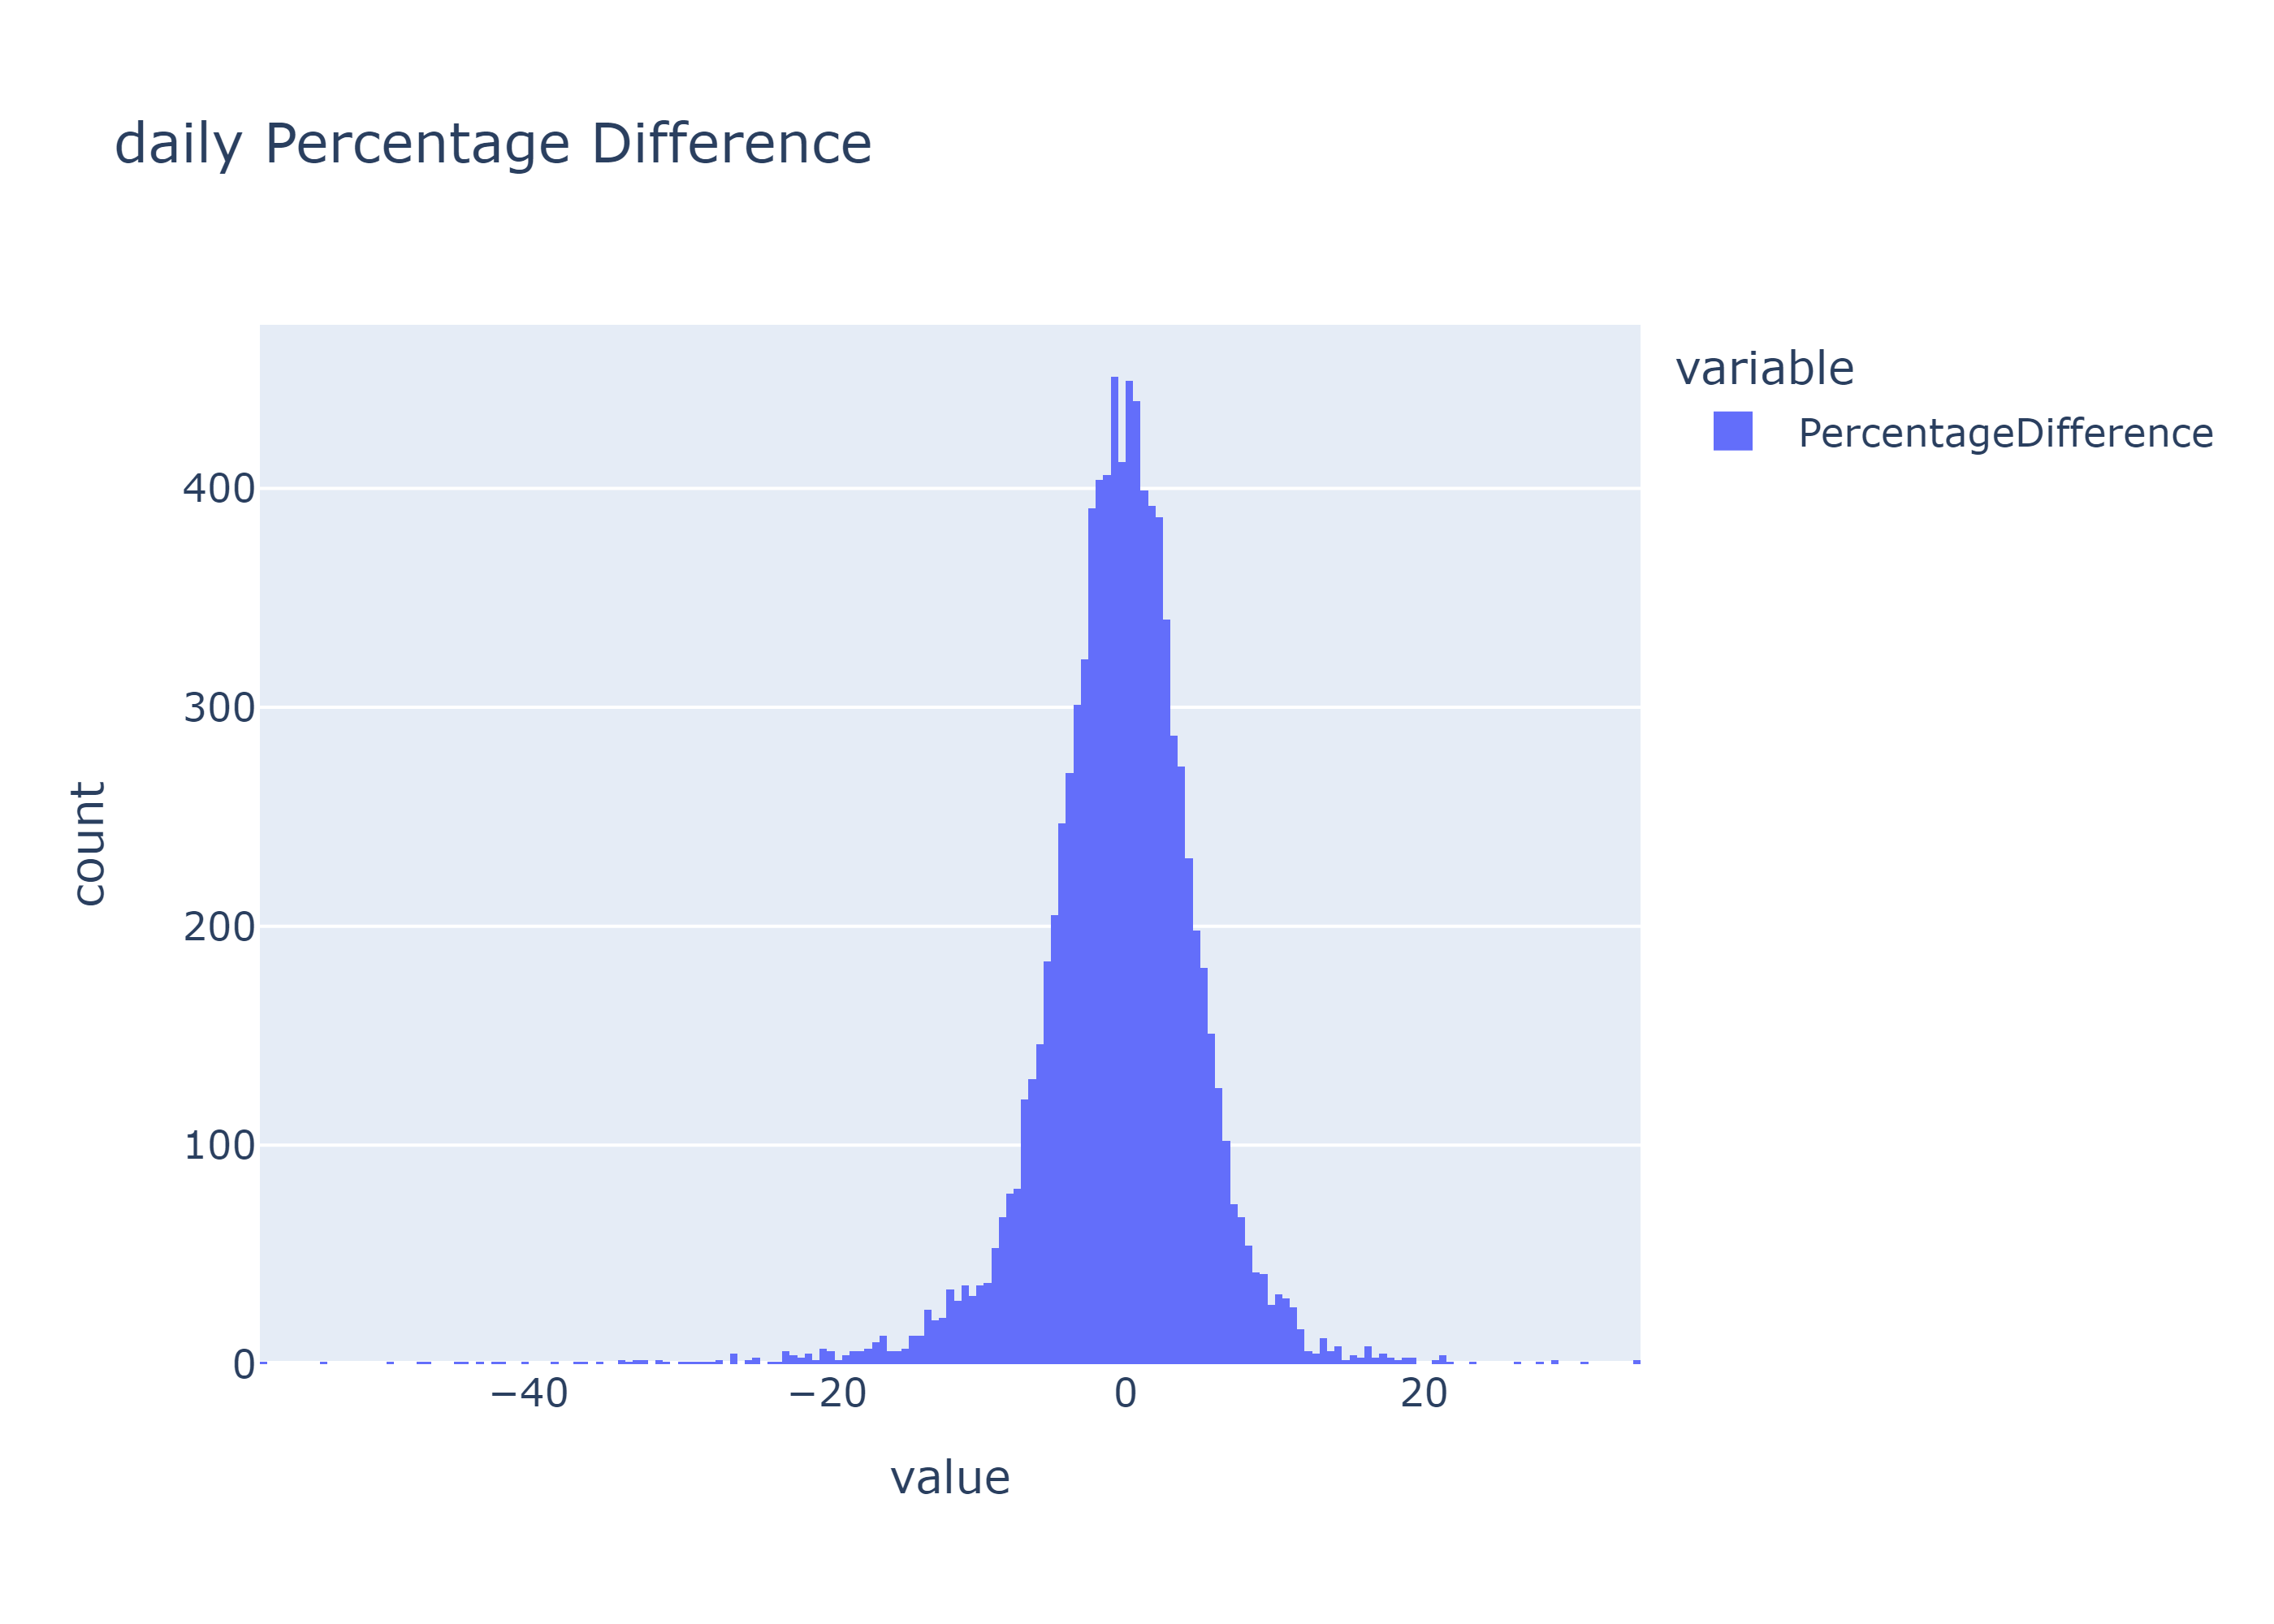

In [63]:
plot_data = df_comp.copy()
fig = px.histogram(plot_data['PercentageDifference'], title='daily Percentage Difference')
confluence_plot(fig)

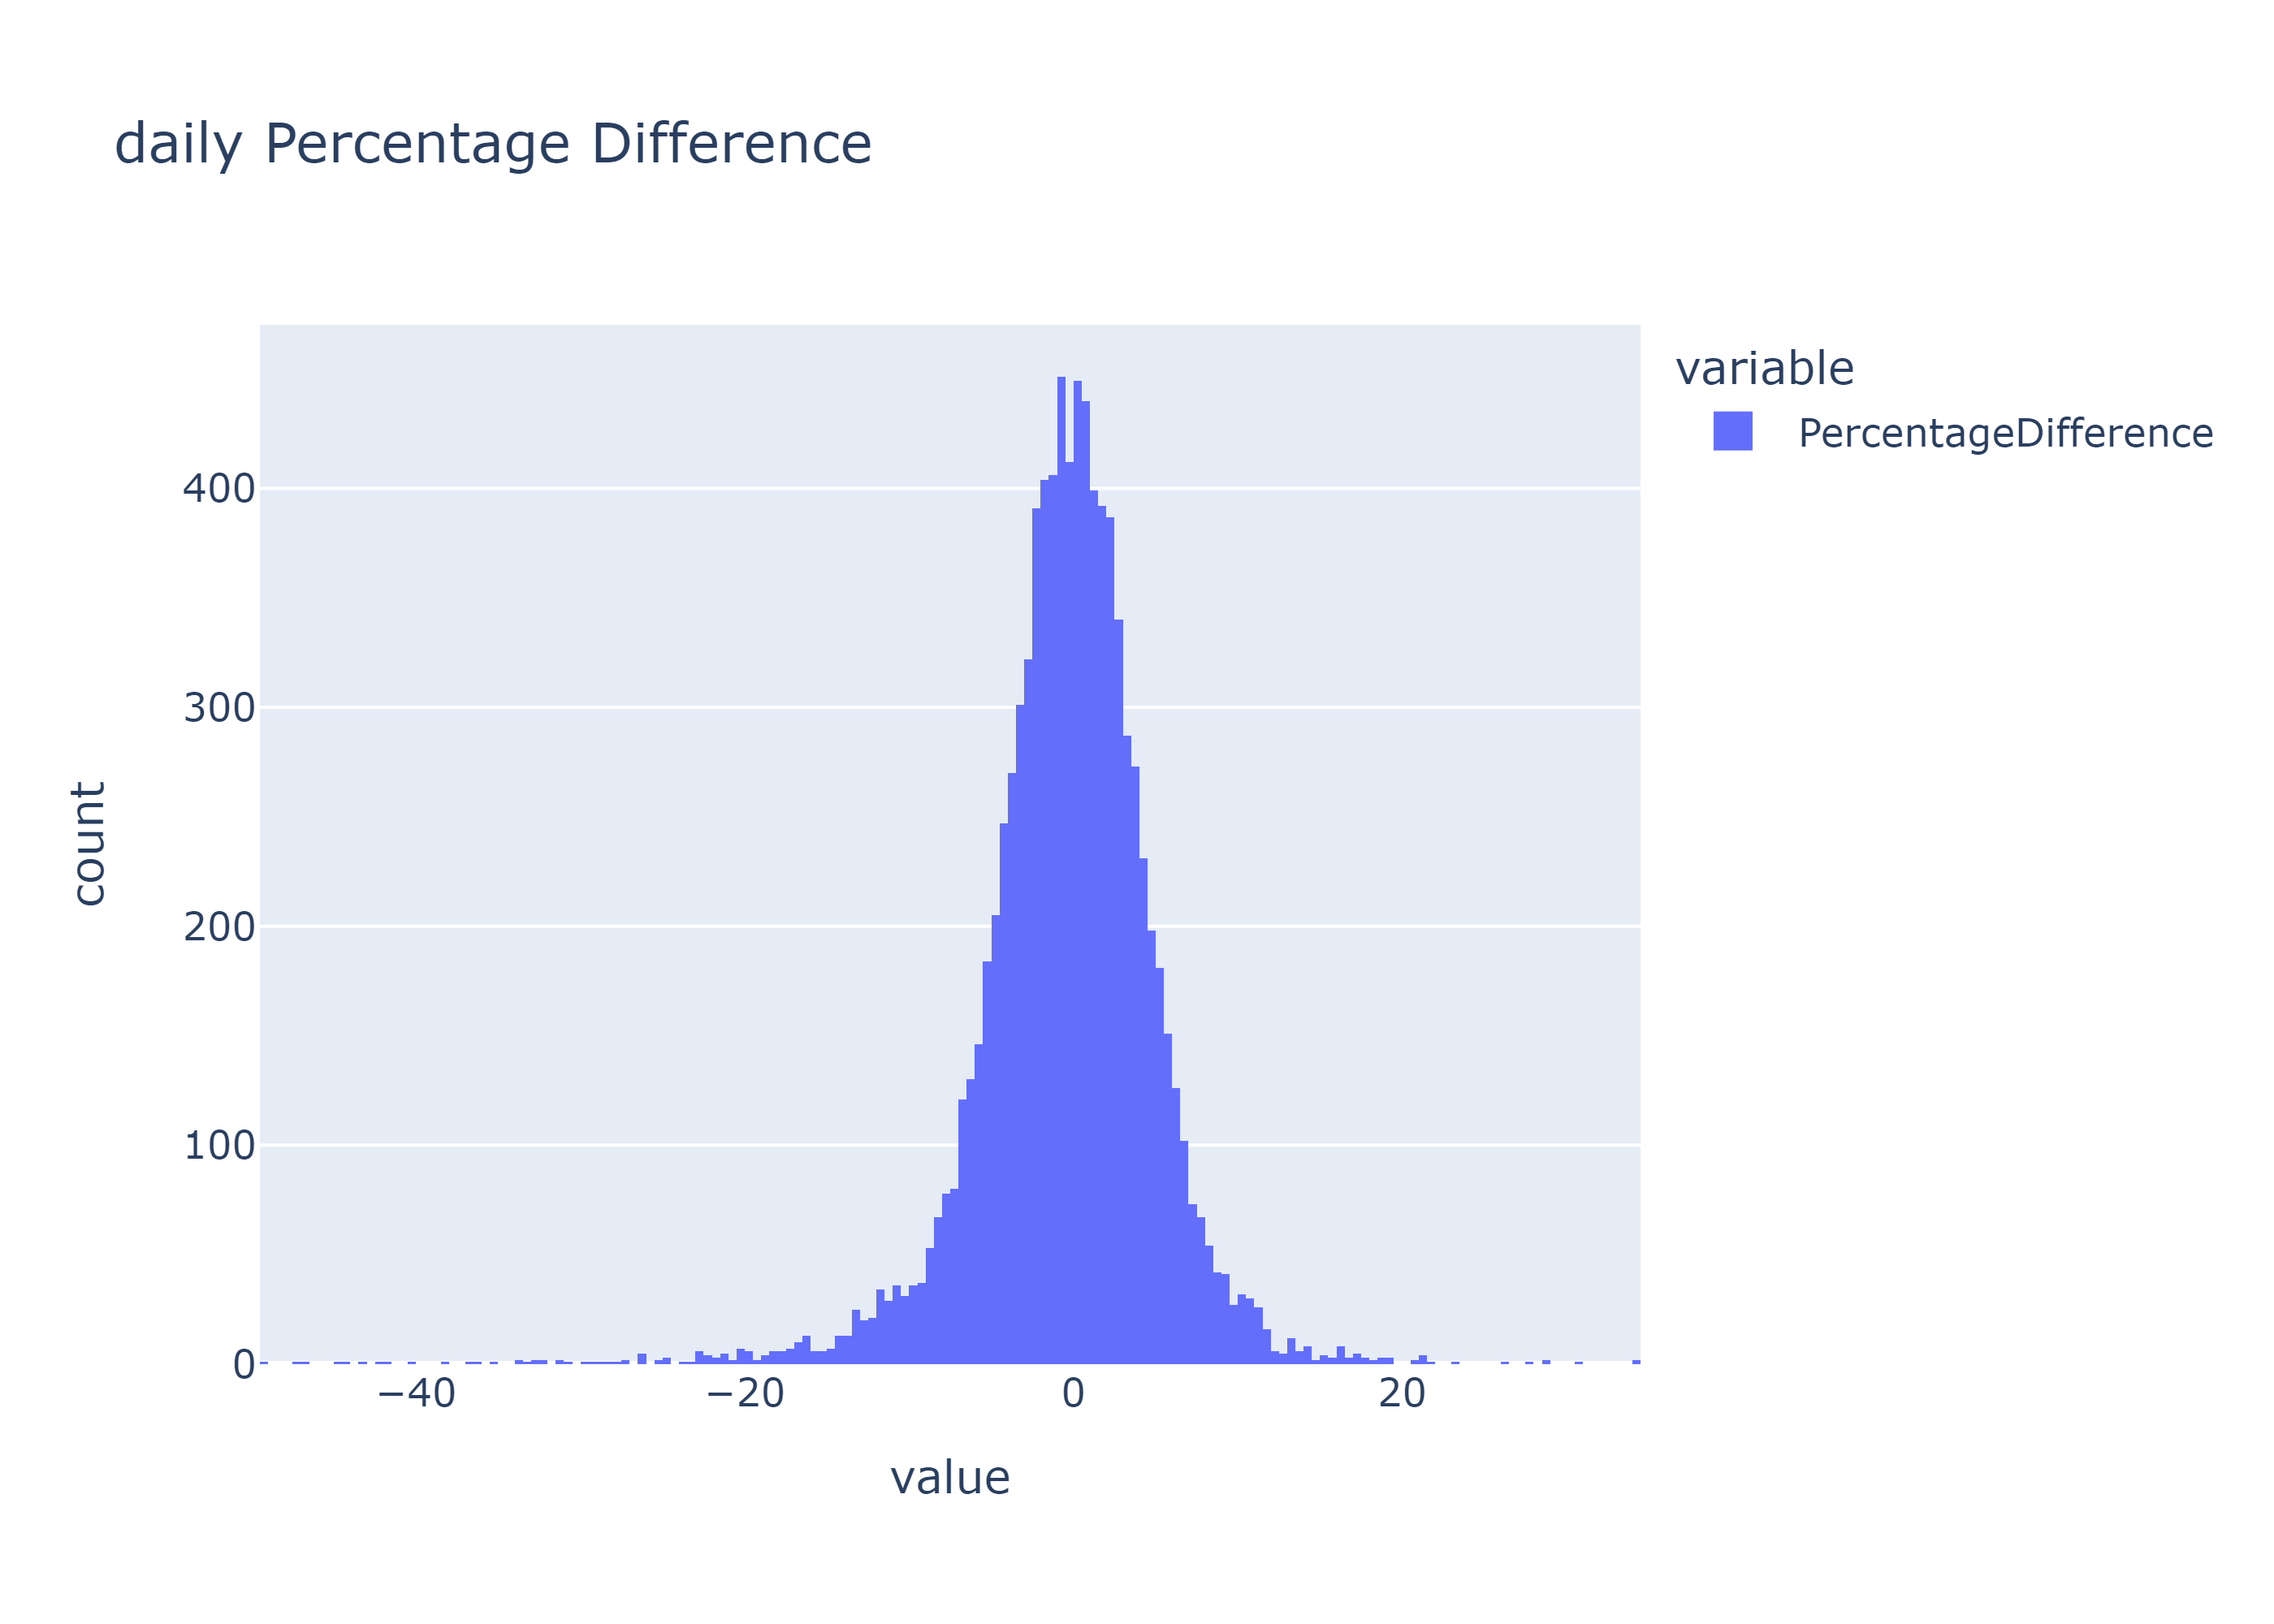

In [64]:
plot_data = df_comp.loc[df_comp['PercentageDifference'] > -50].copy()
fig = px.histogram(plot_data['PercentageDifference'], title='daily Percentage Difference')
confluence_plot(fig)

In [65]:
print(f"Mean Prediction difference: {df_comp['PredictionDifference'].mean():.2f}")
print(f"Mean Percentage difference: {df_comp['PercentageDifference'].mean():.2f}%")
print(f"Mean ABS Percentage difference: {abs(df_comp['PercentageDifference']).mean():.2f}%")

Mean Prediction difference: -13.75
Mean Percentage difference: -0.43%
Mean ABS Percentage difference: 3.86%


### Compare DailyType Uplift

In [66]:
daily_type_0 = test_data_3.copy()
daily_type_0['DailyType'] = 'No'
daily_type_0_preds = model_3.predict(daily_type_0)

daily_type_1 = test_data_3.copy()
daily_type_1['DailyType'] = 'Daily'
daily_type_1_preds = model_3.predict(daily_type_1)

daily_type_2 = test_data_3.copy()
daily_type_2['DailyType'] = 'Enhanced Short Break'
daily_type_2_preds = model_3.predict(daily_type_2)

uplift_a = daily_type_1_preds - daily_type_0_preds
uplift_a_percentage = 100*uplift/daily_type_0_preds

uplift_b = daily_type_2_preds - daily_type_1_preds
uplift_b_percentage = 100*uplift/daily_type_1_preds

uplift_c = daily_type_2_preds - daily_type_0_preds
uplift_c_percentage = 100*uplift/daily_type_0_preds

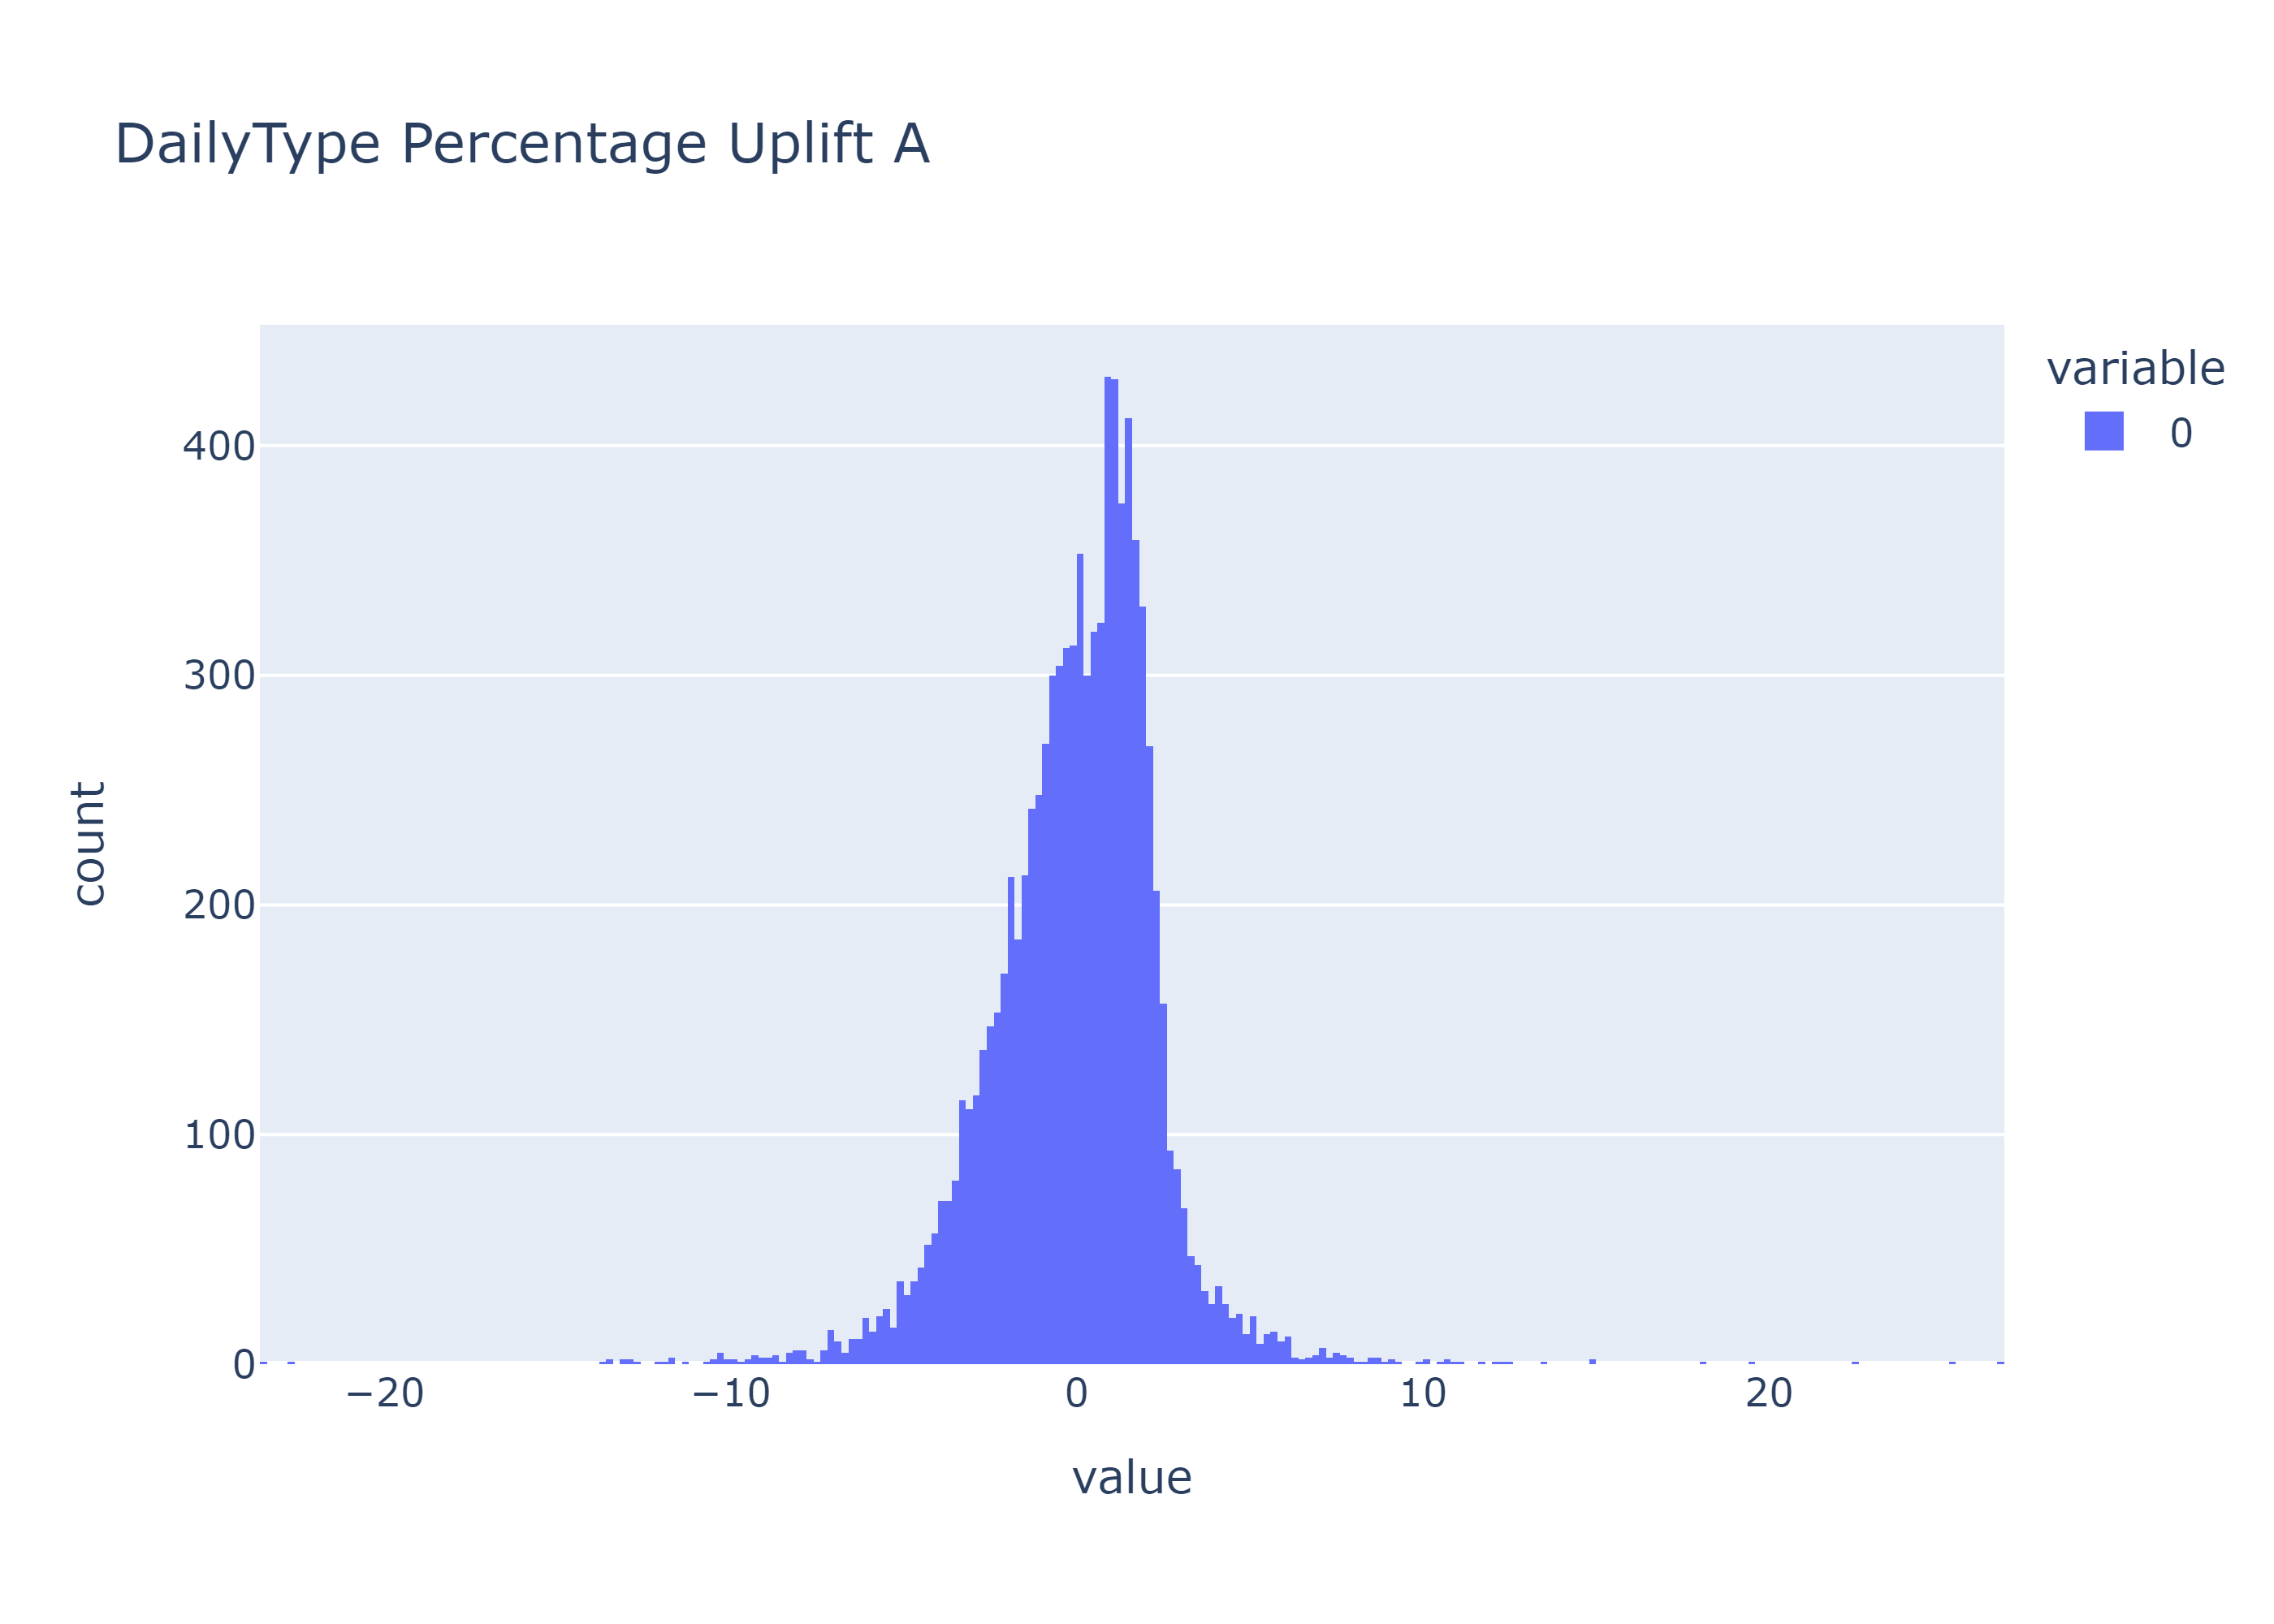

In [67]:
fig = px.histogram(uplift_a_percentage, title='DailyType Percentage Uplift A')
confluence_plot(fig)

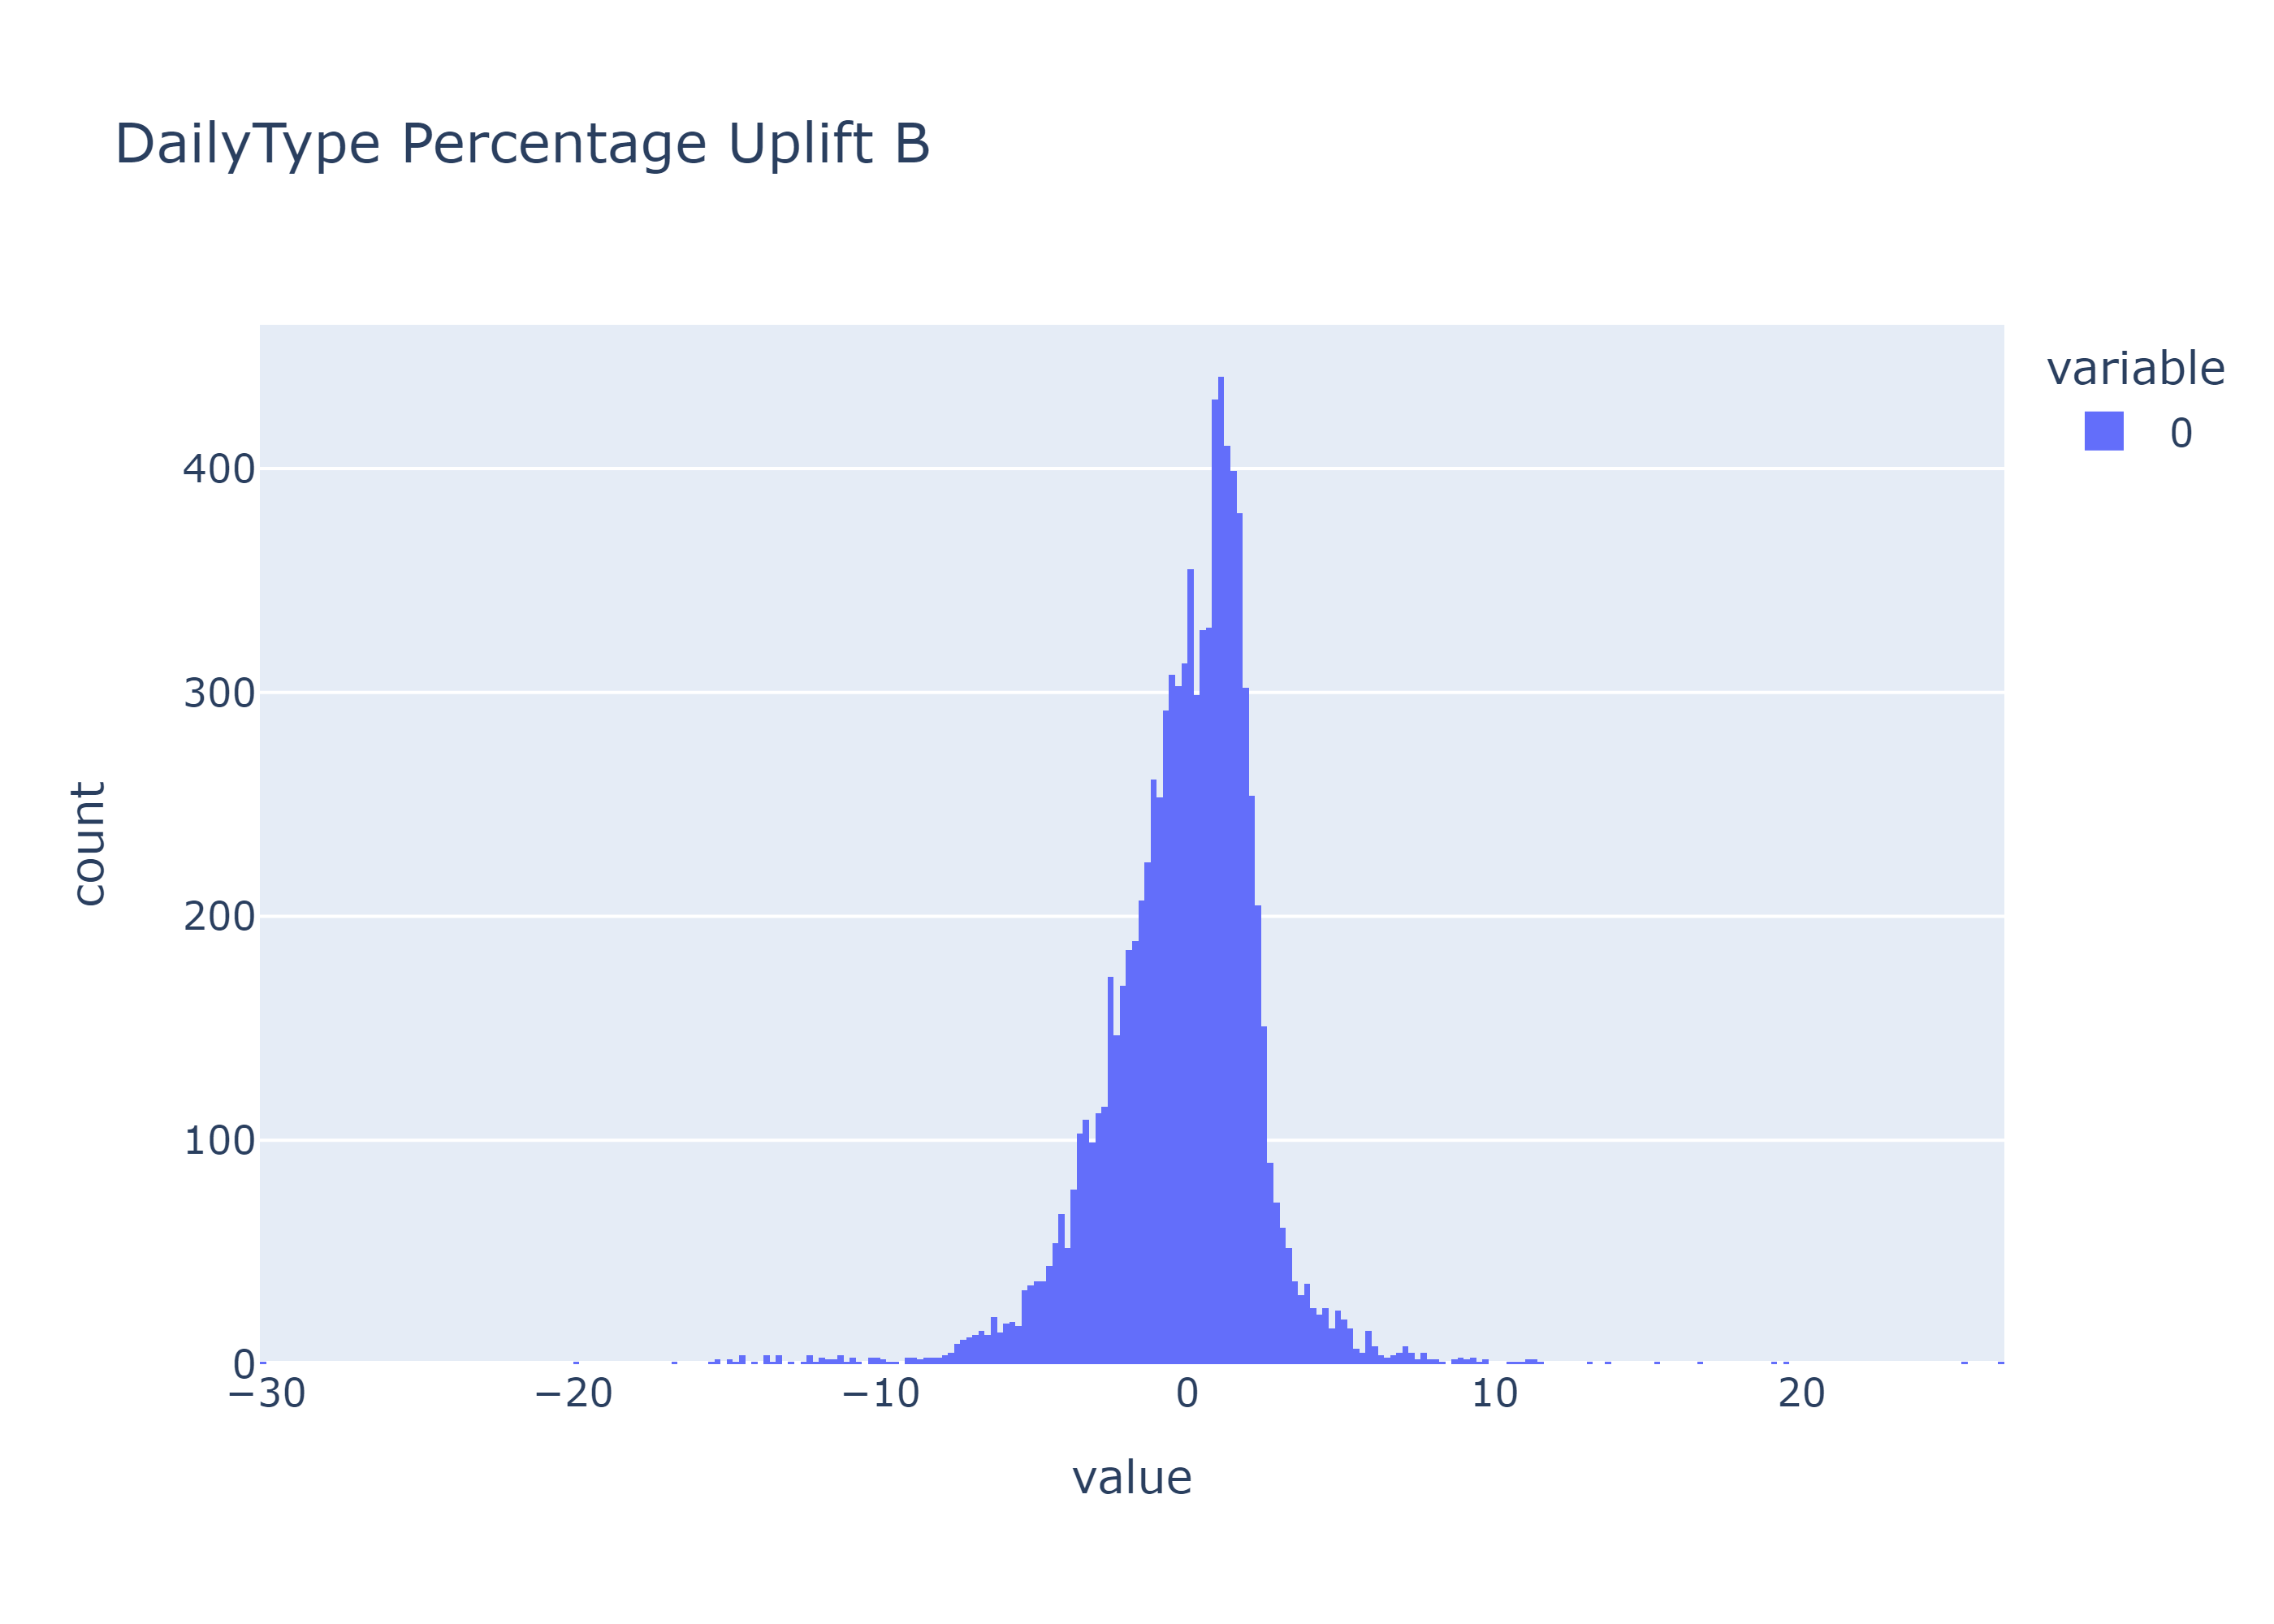

In [68]:
fig = px.histogram(uplift_b_percentage, title='DailyType Percentage Uplift B')
confluence_plot(fig)

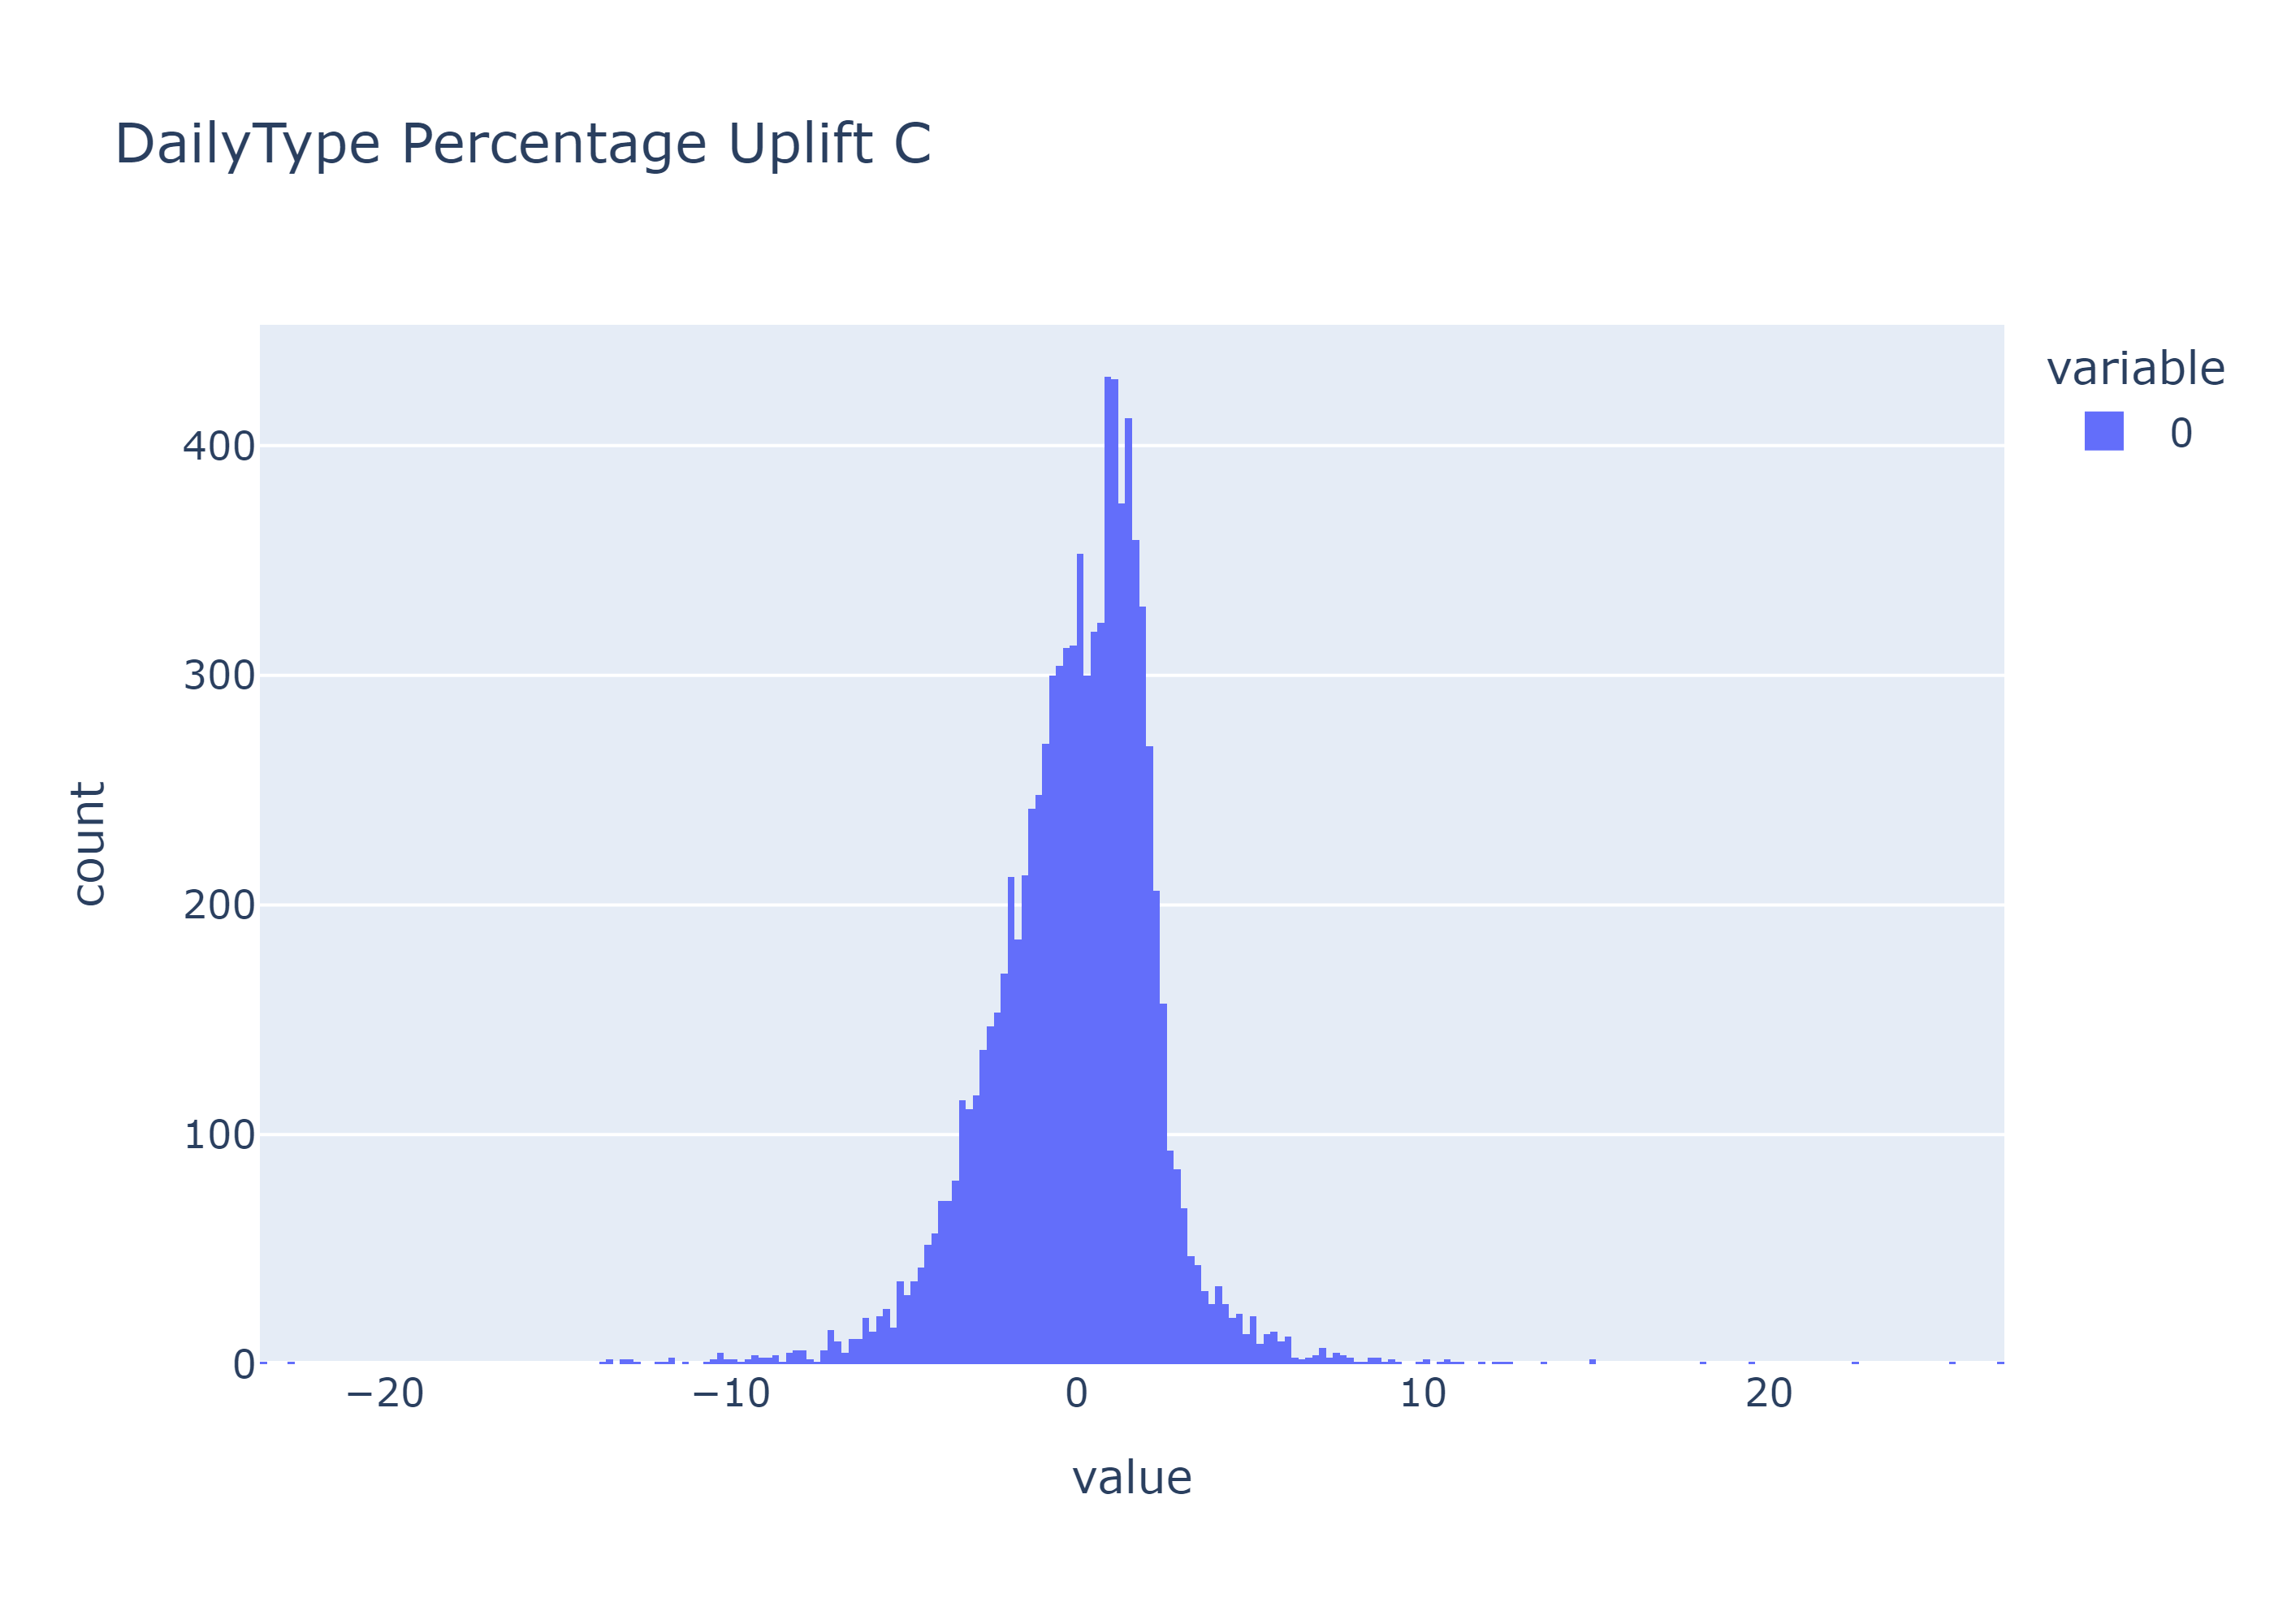

In [69]:
fig = px.histogram(uplift_c_percentage, title='DailyType Percentage Uplift C')
confluence_plot(fig)

In [70]:
print(f"Mean A Prediction Uplift: {uplift_a.mean():.2f}")
print(f"Mean A Percentage Uplift: {uplift_a_percentage.mean():.2f}%")
print(f"Mean A ABS Percentage Uplift: {abs(uplift_a_percentage).mean():.2f}%")

Mean A Prediction Uplift: -29.86
Mean A Percentage Uplift: -0.05%
Mean A ABS Percentage Uplift: 1.79%


In [71]:
print(f"Mean B Prediction Uplift: {uplift_b.mean():.2f}")
print(f"Mean B Percentage Uplift: {uplift_b_percentage.mean():.2f}%")
print(f"Mean B ABS Percentage Uplift: {abs(uplift_b_percentage).mean():.2f}%")

Mean B Prediction Uplift: 364.92
Mean B Percentage Uplift: -0.12%
Mean B ABS Percentage Uplift: 1.83%


In [72]:
print(f"Mean C Prediction Uplift: {uplift_c.mean():.2f}")
print(f"Mean C Percentage Uplift: {uplift_c_percentage.mean():.2f}%")
print(f"Mean C ABS Percentage Uplift: {abs(uplift_c_percentage).mean():.2f}%")

Mean C Prediction Uplift: 335.06
Mean C Percentage Uplift: -0.05%
Mean C ABS Percentage Uplift: 1.79%


### Shortbreaks Impact

In [73]:
df_uplift = pd.DataFrame()
df_uplift['Uplift_A'] = uplift_a
df_uplift['PercentageUplift_A'] = uplift_a_percentage
df_uplift['Uplift_B'] = uplift_b
df_uplift['PercentageUplift_B'] = uplift_b_percentage
df_uplift['Uplift_C'] = uplift_c
df_uplift['PercentageUplift_C'] = uplift_c_percentage
df_uplift['hasShortBreaksAllowed'] = test_data_3['hasShortBreaksAllowed'].copy()
df_uplift['hasLastMinuteBreakAllowed'] = test_data_3['hasLastMinuteBreakAllowed'].copy()

In [74]:
df_uplift.groupby(['hasShortBreaksAllowed', 'hasLastMinuteBreakAllowed']).mean()

Uplift_A  \
hasShortBreaksAllowed hasLastMinuteBreakAllowed              
False                 False                     -67.187916   
True                  False                     -83.828841   
                      True                       -8.544254   

                                                 PercentageUplift_A  \
hasShortBreaksAllowed hasLastMinuteBreakAllowed                       
False                 False                               -0.272604   
True                  False                               -0.306451   
                      True                                 0.062948   

                                                   Uplift_B  \
hasShortBreaksAllowed hasLastMinuteBreakAllowed               
False                 False                      371.025373   
True                  False                      432.373776   
                      True                       351.784931   

                                                 PercentageUplift_B  \
hasShortBreaksAllowed hasLastMinuteBreakAllowed                       
False                 False                               -0.334487   
True                  False                               -0.377382   
                      True                                -0.001921   

                                                   Uplift_C  \
hasShortBreaksAllowed hasLastMinuteBreakAllowed               
False                 False                      303.837456   
True                  False                      348.544935   
                      True                       343.240677   

                                                 PercentageUplift_C  
hasShortBreaksAllowed hasLastMinuteBreakAllowed                      
False                 False                               -0.272604  
True                  False                               -0.306451  
                      True                                 0.062948

## Summary

The accuracy of the models:

<b> Train </b>

|Metric|Without Daily|With Daily|With DailyType|
|------|-------------|----------|--------------|
|sMAPE |        20.19|     20.07|         20.00|
|WAPE  |        16.95|     16.77|         16.77|
|R2    |         0.82|      0.83|          0.83|
|RMSE  |      1469.45|   1449.80|       1459.10|

<b> Test </b>

|Metric|Without Daily|With Daily|With DailyType|
|------|-------------|----------|--------------|
|sMAPE |        28.59|     28.70|         28.55|
|WAPE  |        25.91|     26.01|         25.84|
|R2    |         0.62|      0.62|          0.63|
|RMSE  |      2048.80|   2053.20|       2042.71|

Not much difference in model performance. The feature impact on model predictions doesn't produce significant uplift under counterfactual evaluation.